# imports

In [1]:
import os
import glob
import numpy as np 
import matplotlib.pyplot as plt
import pickle
import time
import matplotlib.image as mpimg
from matplotlib import cm
from moviepy.editor import VideoFileClip
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from skimage.feature import hog
from scipy.ndimage.measurements import label
import cv2
import math
%matplotlib inline

# We plan to use Support vector classifier in this project, so we found a dataset online to use

## Loading dataset

In [2]:
vehicle_images=[]
non_vehicle_images=[]

for root,dirs,files in os.walk('./vehicles/'):
    for file in files:
        if file.endswith('.png'):
            vehicle_images.append(os.path.join(root, file))


for root,dirs,files in os.walk('./non-vehicles/'):
    for file in files:
        if file.endswith('.png'):
            non_vehicle_images.append(os.path.join(root, file))

In [3]:
v_images_number=len(vehicle_images)
nv_images_number=len(non_vehicle_images)
print('number of car images: ',v_images_number)
print('number of non-car images: ',nv_images_number)
print('shape of images: ',cv2.imread(vehicle_images[0]).shape)

number of car images:  8792
number of non-car images:  5381
shape of images:  (64, 64, 3)


### Random vehicle images

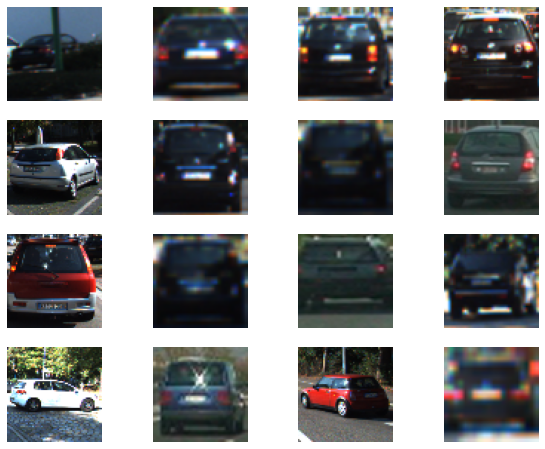

In [4]:
fig,ax=plt.subplots(4,4,figsize=(10,8))
ax= ax.ravel()

for i in range(16):
    image = cv2.imread(vehicle_images[np.random.randint(0,v_images_number)])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    ax[i].axis('off')
    ax[i].imshow(image)

### Random non vehicle images

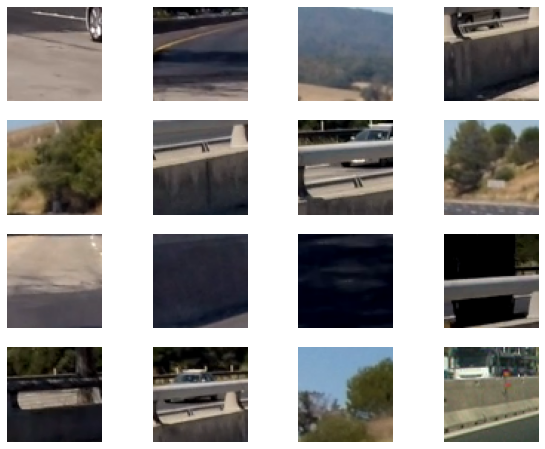

In [5]:
fig,ax=plt.subplots(4,4,figsize=(10,8))
ax= ax.ravel()

for i in range(16):
    image = cv2.imread(non_vehicle_images[np.random.randint(0,nv_images_number)])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    ax[i].axis('off')
    ax[i].imshow(image)

## Hog Feature Extraction

In [6]:
# Compute binned color features by scaling images down 
def get_feature_vector(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features


In [7]:
# Compute color histogram features  
def get_hist_features(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

### Returning HOG features

In [8]:
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                                  visualize=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                       visualize=vis, feature_vector=feature_vec)
        return features

In [9]:
# Extract feature wrapper that extracts and combines all features
def extract_and_combine(imgs, cspace='RGB', orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0, spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256)):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for img in imgs:
            # Read in each one by one
            image = mpimg.imread(img)
            # apply color conversion if other than 'RGB' 

            if cspace != 'RGB':
                if cspace == 'HSV':
                    feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
                elif cspace == 'LUV':
                    feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
                elif cspace == 'HLS':
                    feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
                elif cspace == 'YUV':
                    feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
                elif cspace == 'YCrCb':
                    feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
            else: feature_image = np.copy(image)   

            # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)

            # Apply bin_spatial() to get spatial color features
            spatial_features = get_feature_vector(feature_image, size=spatial_size)
            # Apply color_hist() also with a color space option now
            hist_features = get_hist_features(feature_image, nbins=hist_bins, bins_range=hist_range)
            # Append the new feature vector to the features list
            features.append(np.concatenate((spatial_features, hist_features,hog_features)))
    # Return list of feature vectors
    return features

### Visualizing HOG Feature Extraction

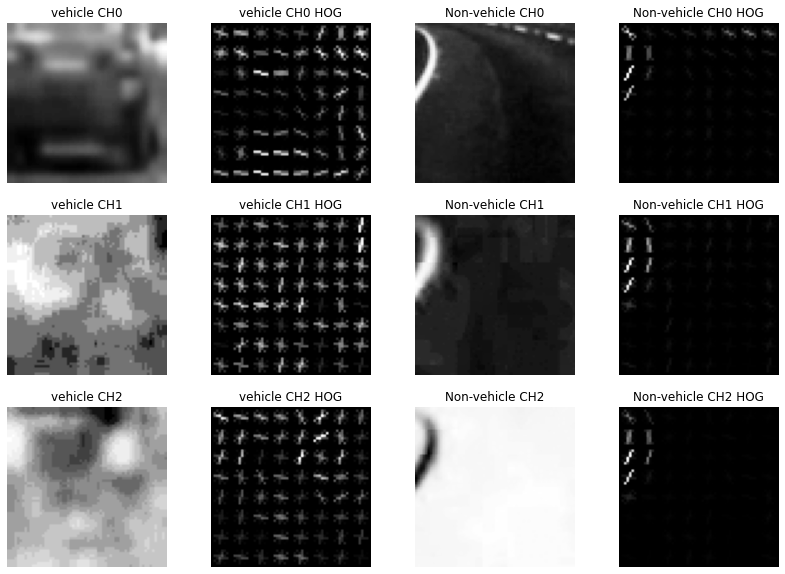

In [10]:
test_image = cv2.imread(vehicle_images[13])
test_image = cv2.cvtColor(test_image, cv2.COLOR_RGB2YCrCb)
non_car_test_image = mpimg.imread(non_vehicle_images[7])
non_car_test_image = cv2.cvtColor(non_car_test_image, cv2.COLOR_RGB2YCrCb)

imgs = []
titles = []
for i in range(3):
    for feature_image, img_type in zip([test_image, non_car_test_image], ['vehicle', 'Non-vehicle']):
        channel = feature_image[:,:,i]
        imgs.append(channel)
        titles.append(img_type + ' CH%d' % i)
        features, hog_image = get_hog_features(channel, orient=12, pix_per_cell=8, cell_per_block=2, 
                        vis=True, feature_vec=False)
        imgs.append(hog_image)
        titles.append(img_type + ' CH%d' % i + ' HOG')
        
fig, axes = plt.subplots(3, 4, sharex=True, sharey=True, figsize=(14, 10))
axes = axes.ravel()
for ax, img, title in zip(axes, imgs, titles):
    ax.imshow(img, cmap='Greys_r')
    ax.set_title(title)
    ax.axis('off')

## Extracting Features for model

In [12]:
spatial = 32
hist_bins = 32
colorspace = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb #YCrCb best
orient = 9
pix_per_cell = 8
cell_per_block = 2
spatial_size= (32, 32)
heat_threshold= 4 # 12
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL" #ALL,0 best
ystart_ystop_scale = [(405, 510, 1), (400, 600, 1.5), (500, 710, 2.5)]

car_features = extract_and_combine(vehicle_images, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_size=(spatial, spatial),
                        hist_bins=hist_bins, hist_range=(0, 256))

non_car_features = extract_and_combine(non_vehicle_images,cspace=colorspace,orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_size=(spatial, spatial),
                        hist_bins=hist_bins, hist_range=(0, 256))

## Preparing training and testing sets

In [13]:
# Create an array stack of feature vectors
X = np.vstack((car_features, non_car_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(non_car_features))))

# Split up data into randomized training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=42)

print('Using spatial binning of:',spatial,'and', hist_bins,'histogram bins')
print('Feature vector length:', len(X_train[0]))

Using spatial binning of: 32 and 32 histogram bins
Feature vector length: 8460


### SVC model

In [14]:
# Use a linear SVC 
model = LinearSVC()

# Check the training time for the SVC
t=time.time()
model.fit(X_train, y_train)
t2 = time.time()

print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(model.score(X_test, y_test), 4))

12.68 Seconds to train SVC...
Test Accuracy of SVC =  0.994


### Saving pickled data for pipeline

In [15]:
# Save data to pickle file
dist_pickle = {}
dist_pickle["svc"] = model
dist_pickle["scaler"] = X_scaler
dist_pickle["orient"] = orient
dist_pickle["pix_per_cell"] = pix_per_cell
dist_pickle["cell_per_block"] = cell_per_block
dist_pickle["spatial"] = spatial
dist_pickle["hist_bins"] = hist_bins
pickle.dump(dist_pickle, open("svc_pickle.p", 'wb') )

## Window Search for HOG

In [16]:
test_images = np.array([plt.imread(i) for i in glob.glob('./test_images/*.jpg')])

In [17]:
# Extracts features using hog sub-sampling and make predictions
def find_cars(img, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, ystart_ystop_scale, h_shift=0, visualisation=False):
    # List of bounding box positions
    bbox_detection_list=[]
    box_vis_list=[]
    # Copy and normalise
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
       
    # Searching different size windows at different scales:
    for (ystart, ystop, scale) in ystart_ystop_scale:
        box_vis=[]
        # Crop
        img_tosearch = img[ystart:ystop, :, :]
        ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YCrCb)
        if scale != 1:
            imshape = ctrans_tosearch.shape
            ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))

        ch1 = ctrans_tosearch[:,:,0]
        ch2 = ctrans_tosearch[:,:,1]
        ch3 = ctrans_tosearch[:,:,2]
        
        # Define blocks and steps as above
        nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 3
        nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
        nfeat_per_block = orient*cell_per_block**2

        # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
        window = 64
        nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
        cells_per_step = 2  # Instead of overlap, define how many cells to step
        nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
        nysteps = (nyblocks - nblocks_per_window) // cells_per_step

        # Compute individual channel HOG features for the entire image
        hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)

        for xb in range(nxsteps):
            for yb in range(nysteps):
                ypos = yb*cells_per_step
                xpos = xb*cells_per_step
                # Extract HOG for this patch
                hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

                xleft = xpos*pix_per_cell
                ytop = ypos*pix_per_cell

                # Extract the image patch
                subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))

                # Get color features
                spatial_features = get_feature_vector(subimg, size=spatial_size)
                hist_features = get_hist_features(subimg, nbins=hist_bins)

                # Scale features and make a prediction
                test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    

                # Make prediction based on trained model 
                test_prediction = svc.predict(test_features)
                
                if(visualisation):
                    xbox_left = np.int(xleft*scale)
                    ytop_draw = np.int(ytop*scale)
                    win_draw = np.int(window*scale)
                    # Append Detection Position to list 
                    box_vis.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                
                if test_prediction == 1:
                    xbox_left = np.int(xleft*scale)
                    ytop_draw = np.int(ytop*scale)
                    win_draw = np.int(window*scale)
                    # Append Detection Position to list 
                    bbox_detection_list.append(((xbox_left+h_shift, ytop_draw+ystart),(xbox_left+win_draw+h_shift,ytop_draw+win_draw+ystart)))
                    # Draw Detection on image
                    cv2.rectangle(draw_img,(xbox_left+h_shift, ytop_draw+ystart),(xbox_left+win_draw+h_shift,ytop_draw+win_draw+ystart),(0,0,255),6) 
        box_vis_list += [box_vis]
    return bbox_detection_list, draw_img, box_vis_list

(-0.5, 1279.5, 719.5, -0.5)

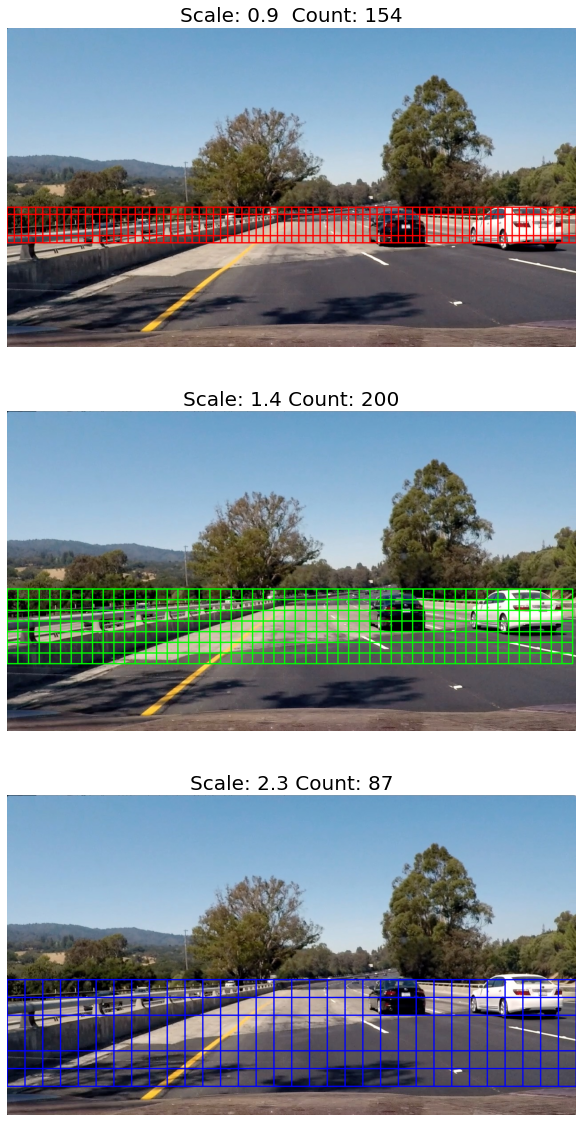

In [18]:
test_image_sliding=test_images[5]
ystart_ystop_scale = [(405, 510, 1), (400, 600, 1.5), (415, 710, 2.5)]
bbox_detection_list, detections, box_vis_list = find_cars(test_image_sliding, model, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, ystart_ystop_scale, h_shift=500, visualisation=True)

def draw_boxes(img, bboxes, thickness=2):
    imcopy = [np.copy(img),np.copy(img),np.copy(img)]
    color=[(255, 0, 0),(0, 255, 0),(0, 0, 255)]
    for i in range(len(bboxes)):
        for bbox in bboxes[i]:
            cv2.rectangle(img=imcopy[i], pt1=bbox[0], pt2=bbox[1],
                          color=color[i], thickness=thickness)
    return imcopy

windows_img = draw_boxes(test_image_sliding, box_vis_list)

f, ((ax1, ax2, ax3)) = plt.subplots(3, 1, figsize=(20,20))
ax1.imshow(windows_img[0])
title = "Scale: 0.9 "  + " Count: " + str(len(box_vis_list[0])) 
ax1.set_title(title, fontsize=20)
ax1.axis("off")
ax2.imshow(windows_img[1])
title = "Scale: 1.4"  + " Count: " + str(len(box_vis_list[1])) 
ax2.set_title(title, fontsize=20)
ax2.axis("off")
ax3.imshow(windows_img[2])
title = "Scale: 2.3"  + " Count: " + str(len(box_vis_list[2])) 
ax3.set_title(title, fontsize=20)
ax3.axis("off")


In [19]:
# Accumulation of labels from last N frames
class Detect_history():
    def __init__ (self):
        # Number labels to store
        self.queue_len = 7 #17 13
        self.queue = []

    # Put new frame
    def put_labels(self, labels):
        if (len(self.queue) > self.queue_len):
            tmp = self.queue.pop(0)
        self.queue.append(labels)
    
    # Get last N frames hot boxes
    def get_labels(self):
        detections = []
        for label in self.queue:
            detections.extend(label)
        return detections

(800, 400) (959, 574)
(1032, 400) (1247, 519)


(-0.5, 1279.5, 719.5, -0.5)

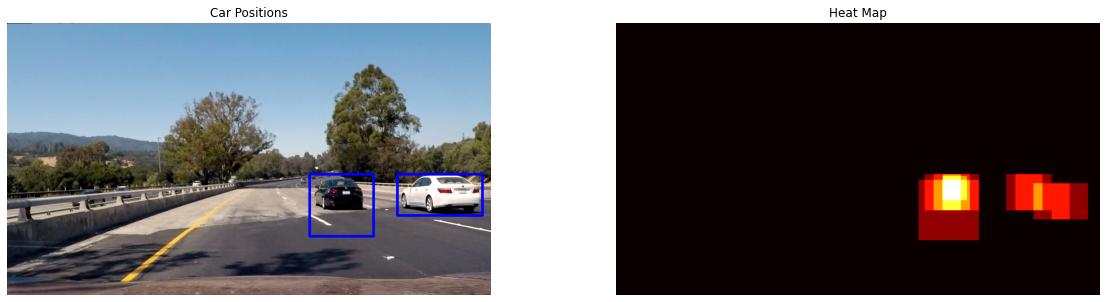

In [20]:
# Read in image similar to one shown above 
image = test_images[5]
blank = np.zeros_like(image[:,:,0]).astype(np.float)

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], (bbox[1][0]+10,bbox[1][1]-10), (0,0,255), 6)
        print(bbox[0],bbox[1])
    # Return the image
    return img


# Using Subsampled HOG windows to get possible detections 
bbox_detection_list, detections, box_vis_list = find_cars(image, model, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins,ystart_ystop_scale)

# Add heat to each box in box list
heatmap = add_heat(blank, bbox_detection_list)

# Find final boxes from heatmap using label function
labels = label(heatmap)
draw_img = draw_labeled_bboxes(np.copy(image), labels)

fig = plt.figure(figsize = (20,5))
plt.subplot(121)
plt.imshow(draw_img)
plt.title('Car Positions')
plt.axis('off')
plt.subplot(122)
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map')
plt.axis('off')


In [23]:
### Parameters
spatial = 32
hist_bins = 32
colorspace = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb #YCrCb best
orient = 9
pix_per_cell = 8
cell_per_block = 2
spatial_size= (32, 32)
heat_threshold= 4 # 12
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL" #ALL,0 best
ystart_ystop_scale = [(405, 510, 1), (400, 600, 1.5), (500, 710, 2.5)]

def process_image(img): 
    
    # Using Subsampled HOG windows to get possible detections 
    bbox_detection_list, detections, box_vis_list = find_cars(img, model, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins,ystart_ystop_scale)

    blank = np.zeros_like(img[:,:,0]).astype(np.float)

    # Smoothing out previous detections
    detect_history.put_labels(bbox_detection_list)
    bbox_detection_list = detect_history.get_labels()

    # Add heat to detections
    heatmap = add_heat(blank, bbox_detection_list)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)

    # Draw bounding box 
    result = draw_labeled_bboxes(np.copy(img), labels)
    
    return result

(816, 400) (959, 495)
(1032, 400) (1247, 519)


(-0.5, 1279.5, 719.5, -0.5)

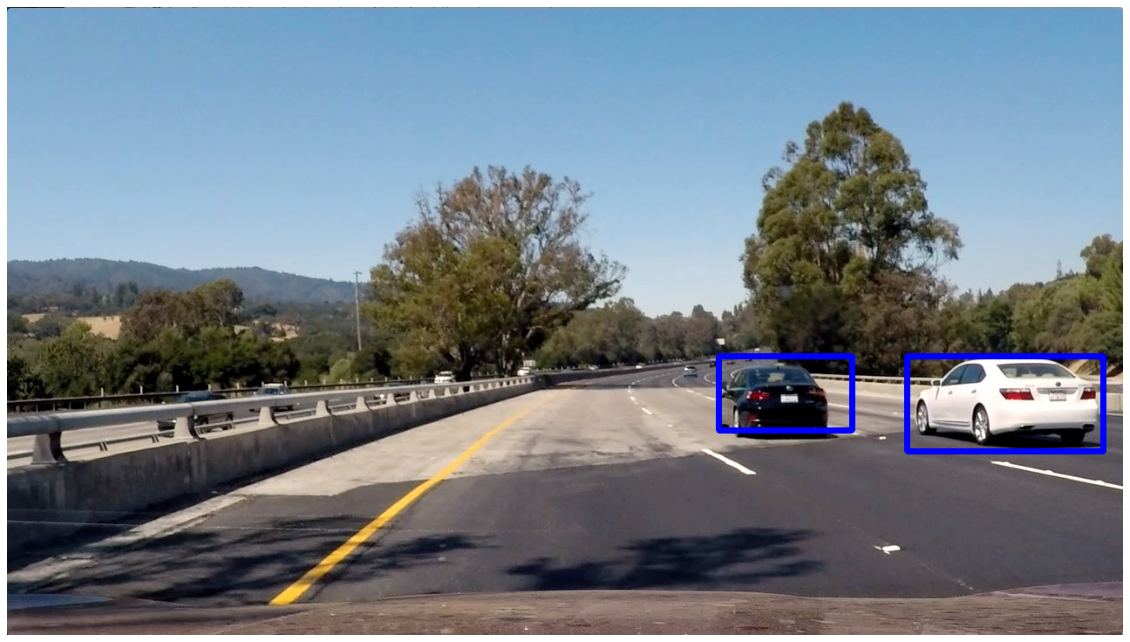

In [25]:
detect_history = Detect_history()

result = process_image(test_images[5])
plt.figure(figsize = (20,20))
plt.imshow(result)
plt.axis("off")

In [27]:
detect_history = Detect_history()
project_video_res = 'project_video_result.mp4'
clip1 = VideoFileClip("project_video.mp4")
project_video_clip = clip1.fl_image(process_image)
project_video_clip.write_videofile(project_video_res, audio=False)

t:  48%|███████████████████████████████▍                                  | 601/1260 [10:43<13:20,  1.22s/it, now=None]

Moviepy - Building video project_video_result.mp4.
Moviepy - Writing video project_video_result.mp4




t:   7%|████▉                                                               | 66/902 [01:03<10:58,  1.27it/s, now=None]


t:  15%|█████████▊                                                         | 132/902 [02:07<13:02,  1.02s/it, now=None]


t:  18%|████████████▎                                                      | 165/902 [02:40<12:22,  1.01s/it, now=None]

(24, 400) (119, 495)



t:  18%|████████████▎                                                      | 166/902 [02:41<12:04,  1.02it/s, now=None]

(0, 400) (119, 495)



t:  19%|████████████▍                                                      | 167/902 [02:42<13:45,  1.12s/it, now=None]

(0, 400) (119, 495)



t:  19%|████████████▍                                                      | 168/902 [02:44<14:51,  1.22s/it, now=None]

(0, 400) (119, 495)



t:  19%|████████████▌                                                      | 169/902 [02:44<12:42,  1.04s/it, now=None]

(0, 400) (119, 495)



t:  19%|████████████▋                                                      | 170/902 [02:45<12:15,  1.01s/it, now=None]

(0, 400) (119, 495)



t:  19%|████████████▋                                                      | 171/902 [02:47<13:46,  1.13s/it, now=None]

(0, 400) (119, 495)



t:  19%|████████████▊                                                      | 172/902 [02:48<14:42,  1.21s/it, now=None]

(0, 400) (119, 495)



t:  19%|████████████▊                                                      | 173/902 [02:49<12:49,  1.06s/it, now=None]

(0, 400) (95, 495)



t:  24%|███████████████▊                                                   | 213/902 [03:26<09:01,  1.27it/s, now=None]

(1128, 400) (1247, 519)



t:  24%|███████████████▉                                                   | 214/902 [03:27<08:45,  1.31it/s, now=None]

(1128, 400) (1247, 519)



t:  24%|███████████████▉                                                   | 215/902 [03:28<10:49,  1.06it/s, now=None]

(1128, 400) (1247, 519)



t:  24%|████████████████                                                   | 216/902 [03:30<12:18,  1.08s/it, now=None]

(1128, 400) (1247, 519)



t:  24%|████████████████                                                   | 217/902 [03:31<11:32,  1.01s/it, now=None]

(1128, 400) (1247, 519)



t:  24%|████████████████▏                                                  | 218/902 [03:31<10:07,  1.13it/s, now=None]

(1128, 400) (1247, 519)



t:  24%|████████████████▎                                                  | 219/902 [03:32<11:10,  1.02it/s, now=None]

(1128, 400) (1247, 519)



t:  24%|████████████████▎                                                  | 220/902 [03:34<12:35,  1.11s/it, now=None]

(1104, 400) (1247, 519)



t:  25%|████████████████▍                                                  | 221/902 [03:35<12:40,  1.12s/it, now=None]

(1104, 400) (1223, 519)



t:  25%|████████████████▍                                                  | 222/902 [03:36<10:56,  1.04it/s, now=None]

(1104, 400) (1223, 519)



t:  25%|████████████████▌                                                  | 223/902 [03:36<09:43,  1.16it/s, now=None]

(1104, 400) (1223, 519)



t:  25%|████████████████▋                                                  | 224/902 [03:37<08:53,  1.27it/s, now=None]

(1104, 400) (1223, 519)



t:  25%|████████████████▋                                                  | 225/902 [03:38<09:48,  1.15it/s, now=None]

(1104, 400) (1223, 543)



t:  25%|████████████████▊                                                  | 226/902 [03:39<11:25,  1.01s/it, now=None]

(1104, 400) (1223, 543)



t:  25%|████████████████▊                                                  | 227/902 [03:41<12:22,  1.10s/it, now=None]

(1104, 400) (1223, 543)



t:  25%|████████████████▉                                                  | 228/902 [03:41<10:44,  1.05it/s, now=None]

(1104, 400) (1223, 543)



t:  25%|█████████████████                                                  | 229/902 [03:42<09:32,  1.17it/s, now=None]

(1104, 400) (1223, 543)



t:  25%|█████████████████                                                  | 230/902 [03:42<08:44,  1.28it/s, now=None]

(1104, 400) (1223, 543)



t:  26%|█████████████████▏                                                 | 231/902 [03:43<09:16,  1.21it/s, now=None]

(1104, 400) (1223, 543)



t:  26%|█████████████████▏                                                 | 232/902 [03:45<11:11,  1.00s/it, now=None]

(1104, 400) (1223, 543)



t:  26%|█████████████████▎                                                 | 233/902 [03:46<12:29,  1.12s/it, now=None]

(1104, 400) (1223, 543)



t:  26%|█████████████████▍                                                 | 234/902 [03:47<10:48,  1.03it/s, now=None]

(1104, 400) (1223, 543)



t:  26%|█████████████████▍                                                 | 235/902 [03:47<09:35,  1.16it/s, now=None]

(1104, 400) (1223, 543)



t:  26%|█████████████████▌                                                 | 236/902 [03:48<08:44,  1.27it/s, now=None]

(1080, 400) (1223, 543)



t:  26%|█████████████████▌                                                 | 237/902 [03:49<08:53,  1.25it/s, now=None]

(1080, 400) (1223, 543)



t:  26%|█████████████████▋                                                 | 238/902 [03:50<10:41,  1.03it/s, now=None]

(1080, 400) (1223, 519)



t:  26%|█████████████████▊                                                 | 239/902 [03:52<11:58,  1.08s/it, now=None]

(1080, 400) (1223, 519)



t:  27%|█████████████████▊                                                 | 240/902 [03:52<10:58,  1.00it/s, now=None]

(1080, 400) (1199, 519)



t:  27%|█████████████████▉                                                 | 241/902 [03:53<09:43,  1.13it/s, now=None]

(1080, 400) (1199, 519)



t:  27%|█████████████████▉                                                 | 242/902 [03:54<11:09,  1.01s/it, now=None]

(1080, 400) (1199, 519)



t:  27%|██████████████████                                                 | 243/902 [03:56<12:18,  1.12s/it, now=None]

(1080, 400) (1199, 519)



t:  27%|██████████████████                                                 | 244/902 [03:57<11:59,  1.09s/it, now=None]

(1080, 400) (1199, 519)



t:  27%|██████████████████▏                                                | 245/902 [03:57<10:23,  1.05it/s, now=None]

(1080, 400) (1199, 519)



t:  27%|██████████████████▎                                                | 246/902 [03:58<10:44,  1.02it/s, now=None]

(1080, 400) (1199, 495)



t:  27%|██████████████████▎                                                | 247/902 [04:00<11:56,  1.09s/it, now=None]

(1080, 400) (1199, 495)



t:  27%|██████████████████▍                                                | 248/902 [04:01<12:35,  1.15s/it, now=None]

(1080, 400) (1199, 495)



t:  28%|██████████████████▍                                                | 249/902 [04:02<10:46,  1.01it/s, now=None]

(1080, 400) (1199, 495)



t:  28%|██████████████████▌                                                | 250/902 [04:02<09:31,  1.14it/s, now=None]

(1080, 400) (1199, 495)



t:  28%|██████████████████▋                                                | 251/902 [04:03<08:38,  1.26it/s, now=None]

(1080, 400) (1199, 495)



t:  28%|██████████████████▋                                                | 252/902 [04:04<08:58,  1.21it/s, now=None]

(1080, 400) (1199, 495)



t:  28%|██████████████████▊                                                | 253/902 [04:05<10:42,  1.01it/s, now=None]

(1080, 400) (1199, 495)



t:  28%|██████████████████▊                                                | 254/902 [04:06<11:53,  1.10s/it, now=None]

(1080, 400) (1199, 495)



t:  28%|██████████████████▉                                                | 255/902 [04:07<10:32,  1.02it/s, now=None]

(1080, 400) (1199, 495)



t:  28%|███████████████████                                                | 256/902 [04:08<09:20,  1.15it/s, now=None]

(1080, 400) (1199, 495)



t:  28%|███████████████████                                                | 257/902 [04:08<08:30,  1.26it/s, now=None]

(1080, 400) (1199, 495)



t:  29%|███████████████████▏                                               | 258/902 [04:09<08:20,  1.29it/s, now=None]

(1080, 400) (1199, 495)



t:  29%|███████████████████▏                                               | 259/902 [04:10<10:11,  1.05it/s, now=None]

(1080, 400) (1199, 495)



t:  29%|███████████████████▎                                               | 260/902 [04:12<11:27,  1.07s/it, now=None]

(1080, 400) (1247, 519)



t:  29%|███████████████████▍                                               | 261/902 [04:13<10:46,  1.01s/it, now=None]

(1080, 400) (1247, 519)



t:  29%|███████████████████▍                                               | 262/902 [04:13<09:29,  1.12it/s, now=None]

(1080, 400) (1247, 519)



t:  29%|███████████████████▌                                               | 263/902 [04:14<08:35,  1.24it/s, now=None]

(1080, 400) (1247, 519)



t:  29%|███████████████████▌                                               | 264/902 [04:14<07:56,  1.34it/s, now=None]

(1080, 400) (1247, 519)



t:  29%|███████████████████▋                                               | 265/902 [04:16<09:48,  1.08it/s, now=None]

(1080, 400) (1247, 519)



t:  29%|███████████████████▊                                               | 266/902 [04:17<11:11,  1.06s/it, now=None]

(1080, 400) (1247, 519)



t:  30%|███████████████████▊                                               | 267/902 [04:18<11:02,  1.04s/it, now=None]

(1080, 400) (1247, 519)



t:  30%|███████████████████▉                                               | 268/902 [04:19<09:39,  1.09it/s, now=None]

(1080, 400) (1247, 519)



t:  30%|███████████████████▉                                               | 269/902 [04:20<10:07,  1.04it/s, now=None]

(1080, 400) (1247, 519)



t:  30%|████████████████████                                               | 270/902 [04:21<11:24,  1.08s/it, now=None]

(1080, 400) (1247, 519)



t:  30%|████████████████████▏                                              | 271/902 [04:23<12:04,  1.15s/it, now=None]

(1080, 400) (1247, 519)



t:  30%|████████████████████▏                                              | 272/902 [04:23<10:46,  1.03s/it, now=None]

(1080, 400) (1247, 519)



t:  30%|████████████████████▎                                              | 273/902 [04:24<09:43,  1.08it/s, now=None]

(1056, 400) (1175, 495)



t:  30%|████████████████████▎                                              | 274/902 [04:25<09:02,  1.16it/s, now=None]

(1056, 400) (1175, 495)



t:  30%|████████████████████▍                                              | 275/902 [04:26<10:50,  1.04s/it, now=None]

(1056, 400) (1175, 495)



t:  31%|████████████████████▌                                              | 276/902 [04:28<12:06,  1.16s/it, now=None]

(1056, 400) (1175, 495)



t:  31%|████████████████████▌                                              | 277/902 [04:29<11:23,  1.09s/it, now=None]

(1056, 400) (1175, 519)



t:  31%|████████████████████▋                                              | 278/902 [04:29<10:08,  1.03it/s, now=None]

(1056, 400) (1223, 519)



t:  31%|████████████████████▋                                              | 279/902 [04:30<09:14,  1.12it/s, now=None]

(1056, 400) (1223, 519)



t:  31%|████████████████████▊                                              | 280/902 [04:31<09:02,  1.15it/s, now=None]

(1056, 400) (1223, 519)



t:  31%|████████████████████▊                                              | 281/902 [04:32<10:36,  1.03s/it, now=None]

(1056, 400) (1231, 519)



t:  31%|████████████████████▉                                              | 282/902 [04:34<11:41,  1.13s/it, now=None]

(1056, 400) (1231, 519)



t:  31%|█████████████████████                                              | 283/902 [04:34<10:35,  1.03s/it, now=None]

(1056, 400) (1231, 519)



t:  31%|█████████████████████                                              | 284/902 [04:35<09:19,  1.10it/s, now=None]

(1056, 400) (1231, 519)



t:  32%|█████████████████████▏                                             | 285/902 [04:36<10:36,  1.03s/it, now=None]

(1056, 400) (1231, 519)



t:  32%|█████████████████████▏                                             | 286/902 [04:38<11:37,  1.13s/it, now=None]

(1056, 400) (1231, 519)



t:  32%|█████████████████████▎                                             | 287/902 [04:39<11:15,  1.10s/it, now=None]

(1056, 400) (1231, 519)



t:  32%|█████████████████████▍                                             | 288/902 [04:39<09:44,  1.05it/s, now=None]

(1056, 400) (1231, 519)



t:  32%|█████████████████████▍                                             | 289/902 [04:40<10:06,  1.01it/s, now=None]

(1056, 400) (1231, 519)



t:  32%|█████████████████████▌                                             | 290/902 [04:42<11:17,  1.11s/it, now=None]

(1056, 400) (1223, 519)



t:  32%|█████████████████████▌                                             | 291/902 [04:43<11:47,  1.16s/it, now=None]

(1056, 400) (1223, 519)



t:  32%|█████████████████████▋                                             | 292/902 [04:44<10:07,  1.00it/s, now=None]

(1056, 400) (1223, 519)



t:  32%|█████████████████████▊                                             | 293/902 [04:44<08:55,  1.14it/s, now=None]

(1056, 400) (1223, 519)



t:  33%|█████████████████████▊                                             | 294/902 [04:45<08:06,  1.25it/s, now=None]

(1056, 400) (1175, 519)



t:  33%|█████████████████████▉                                             | 295/902 [04:46<08:29,  1.19it/s, now=None]

(1056, 400) (1175, 519)



t:  33%|█████████████████████▉                                             | 296/902 [04:47<10:07,  1.00s/it, now=None]

(120, 400) (215, 495)
(1056, 400) (1215, 519)



t:  33%|██████████████████████                                             | 297/902 [04:49<11:13,  1.11s/it, now=None]

(120, 400) (215, 495)
(1056, 400) (1215, 519)



t:  33%|██████████████████████▏                                            | 298/902 [04:49<09:48,  1.03it/s, now=None]

(120, 400) (215, 495)
(1056, 400) (1215, 519)



t:  33%|██████████████████████▏                                            | 299/902 [04:50<08:41,  1.16it/s, now=None]

(120, 400) (215, 495)
(1032, 400) (1215, 519)



t:  33%|██████████████████████▎                                            | 300/902 [04:50<07:56,  1.26it/s, now=None]

(120, 400) (215, 495)
(1032, 400) (1215, 519)



t:  33%|██████████████████████▎                                            | 301/902 [04:51<08:00,  1.25it/s, now=None]

(120, 400) (215, 495)
(1032, 400) (1215, 519)



t:  33%|██████████████████████▍                                            | 302/902 [04:53<09:41,  1.03it/s, now=None]

(120, 400) (215, 495)
(1032, 400) (1215, 519)



t:  34%|██████████████████████▌                                            | 303/902 [04:54<10:49,  1.08s/it, now=None]

(120, 400) (215, 495)
(1032, 400) (1215, 519)



t:  34%|██████████████████████▌                                            | 304/902 [04:55<09:56,  1.00it/s, now=None]

(1032, 400) (1215, 519)



t:  34%|██████████████████████▋                                            | 305/902 [04:55<08:44,  1.14it/s, now=None]

(1032, 400) (1199, 519)



t:  34%|██████████████████████▋                                            | 306/902 [04:56<07:56,  1.25it/s, now=None]

(1032, 400) (1199, 519)



t:  34%|██████████████████████▊                                            | 307/902 [04:57<07:26,  1.33it/s, now=None]

(1032, 400) (1199, 519)



t:  34%|██████████████████████▉                                            | 308/902 [04:58<09:15,  1.07it/s, now=None]

(1032, 400) (1199, 519)



t:  34%|██████████████████████▉                                            | 309/902 [04:59<10:26,  1.06s/it, now=None]

(1032, 400) (1199, 495)



t:  34%|███████████████████████                                            | 310/902 [05:00<10:09,  1.03s/it, now=None]

(1032, 400) (1199, 519)



t:  34%|███████████████████████                                            | 311/902 [05:01<08:54,  1.11it/s, now=None]

(1032, 400) (1199, 519)



t:  35%|███████████████████████▏                                           | 312/902 [05:02<09:33,  1.03it/s, now=None]

(1032, 400) (1199, 519)



t:  35%|███████████████████████▏                                           | 313/902 [05:03<10:41,  1.09s/it, now=None]

(1032, 400) (1199, 519)



t:  35%|███████████████████████▎                                           | 314/902 [05:05<11:04,  1.13s/it, now=None]

(1032, 400) (1199, 519)



t:  35%|███████████████████████▍                                           | 315/902 [05:05<09:32,  1.02it/s, now=None]

(1032, 400) (1199, 519)



t:  35%|███████████████████████▍                                           | 316/902 [05:06<08:33,  1.14it/s, now=None]

(1032, 400) (1199, 519)



t:  35%|███████████████████████▌                                           | 317/902 [05:06<07:46,  1.26it/s, now=None]

(1032, 400) (1199, 519)



t:  35%|███████████████████████▌                                           | 318/902 [05:08<08:53,  1.10it/s, now=None]

(1032, 400) (1199, 519)



t:  35%|███████████████████████▋                                           | 319/902 [05:09<10:44,  1.11s/it, now=None]

(1032, 400) (1199, 519)



t:  35%|███████████████████████▊                                           | 320/902 [05:10<10:56,  1.13s/it, now=None]

(1032, 400) (1151, 519)



t:  36%|███████████████████████▊                                           | 321/902 [05:11<09:34,  1.01it/s, now=None]

(1032, 400) (1151, 519)



t:  36%|███████████████████████▉                                           | 322/902 [05:12<08:30,  1.14it/s, now=None]

(1032, 400) (1151, 519)



t:  36%|███████████████████████▉                                           | 323/902 [05:12<07:44,  1.25it/s, now=None]

(1032, 400) (1151, 519)



t:  36%|████████████████████████                                           | 324/902 [05:14<08:57,  1.08it/s, now=None]

(1032, 400) (1151, 519)



t:  36%|████████████████████████▏                                          | 325/902 [05:15<10:09,  1.06s/it, now=None]

(1032, 400) (1151, 519)



t:  36%|████████████████████████▏                                          | 326/902 [05:16<10:23,  1.08s/it, now=None]

(1032, 400) (1175, 519)



t:  36%|████████████████████████▎                                          | 327/902 [05:17<09:00,  1.06it/s, now=None]

(1032, 400) (1247, 519)



t:  36%|████████████████████████▎                                          | 328/902 [05:18<09:01,  1.06it/s, now=None]

(1032, 400) (1247, 519)



t:  36%|████████████████████████▍                                          | 329/902 [05:19<10:17,  1.08s/it, now=None]

(1032, 400) (1247, 519)



t:  37%|████████████████████████▌                                          | 330/902 [05:20<11:09,  1.17s/it, now=None]

(1032, 400) (1247, 519)



t:  37%|████████████████████████▌                                          | 331/902 [05:21<09:34,  1.01s/it, now=None]

(1032, 400) (1247, 519)



t:  37%|████████████████████████▋                                          | 332/902 [05:22<08:43,  1.09it/s, now=None]

(1032, 400) (1247, 519)



t:  37%|████████████████████████▋                                          | 333/902 [05:23<10:01,  1.06s/it, now=None]

(1032, 400) (1247, 519)



t:  37%|████████████████████████▊                                          | 334/902 [05:24<10:54,  1.15s/it, now=None]

(1008, 400) (1247, 519)



t:  37%|████████████████████████▉                                          | 335/902 [05:25<10:06,  1.07s/it, now=None]

(1008, 400) (1247, 519)



t:  37%|████████████████████████▉                                          | 336/902 [05:26<08:48,  1.07it/s, now=None]

(1008, 400) (1247, 519)



t:  37%|█████████████████████████                                          | 337/902 [05:27<07:52,  1.20it/s, now=None]

(1008, 400) (1247, 519)



t:  37%|█████████████████████████                                          | 338/902 [05:27<07:15,  1.30it/s, now=None]

(1008, 400) (1247, 519)



t:  38%|█████████████████████████▏                                         | 339/902 [05:29<08:56,  1.05it/s, now=None]

(1008, 400) (1247, 519)



t:  38%|█████████████████████████▎                                         | 340/902 [05:30<10:08,  1.08s/it, now=None]

(1008, 400) (1247, 519)



t:  38%|█████████████████████████▎                                         | 341/902 [05:31<09:49,  1.05s/it, now=None]

(1008, 400) (1247, 519)



t:  38%|█████████████████████████▍                                         | 342/902 [05:32<08:36,  1.08it/s, now=None]

(1008, 400) (1247, 519)



t:  38%|█████████████████████████▍                                         | 343/902 [05:33<09:14,  1.01it/s, now=None]

(1008, 400) (1247, 519)



t:  38%|█████████████████████████▌                                         | 344/902 [05:34<10:14,  1.10s/it, now=None]

(1008, 400) (1247, 519)



t:  38%|█████████████████████████▋                                         | 345/902 [05:35<10:32,  1.14s/it, now=None]

(1008, 400) (1175, 519)



t:  38%|█████████████████████████▋                                         | 346/902 [05:36<09:03,  1.02it/s, now=None]

(1008, 400) (1175, 519)



t:  38%|█████████████████████████▊                                         | 347/902 [05:36<08:02,  1.15it/s, now=None]

(1008, 400) (1175, 519)



t:  39%|█████████████████████████▊                                         | 348/902 [05:37<07:20,  1.26it/s, now=None]

(1008, 400) (1175, 519)



t:  39%|█████████████████████████▉                                         | 349/902 [05:38<07:54,  1.17it/s, now=None]

(1008, 400) (1175, 519)



t:  39%|█████████████████████████▉                                         | 350/902 [05:39<09:24,  1.02s/it, now=None]

(1008, 400) (1175, 519)



t:  39%|██████████████████████████                                         | 351/902 [05:41<10:14,  1.11s/it, now=None]

(1008, 400) (1223, 519)



t:  39%|██████████████████████████▏                                        | 352/902 [05:41<08:53,  1.03it/s, now=None]

(1008, 400) (1223, 519)



t:  39%|██████████████████████████▏                                        | 353/902 [05:42<07:54,  1.16it/s, now=None]

(1008, 400) (1223, 519)



t:  39%|██████████████████████████▎                                        | 354/902 [05:43<07:12,  1.27it/s, now=None]

(1008, 400) (1223, 519)



t:  39%|██████████████████████████▎                                        | 355/902 [05:44<07:37,  1.20it/s, now=None]

(1008, 400) (1247, 519)



t:  39%|██████████████████████████▍                                        | 356/902 [05:45<09:03,  1.01it/s, now=None]

(1008, 400) (1247, 519)



t:  40%|██████████████████████████▌                                        | 357/902 [05:46<10:04,  1.11s/it, now=None]

(1008, 400) (1247, 519)



t:  40%|██████████████████████████▌                                        | 358/902 [05:47<08:51,  1.02it/s, now=None]

(1008, 400) (1247, 519)



t:  40%|██████████████████████████▋                                        | 359/902 [05:48<08:03,  1.12it/s, now=None]

(1008, 400) (1247, 519)



t:  40%|██████████████████████████▋                                        | 360/902 [05:49<09:18,  1.03s/it, now=None]

(1008, 400) (1247, 519)



t:  40%|██████████████████████████▊                                        | 361/902 [05:50<10:17,  1.14s/it, now=None]

(1008, 400) (1247, 519)



t:  40%|██████████████████████████▉                                        | 362/902 [05:51<09:35,  1.07s/it, now=None]

(1008, 400) (1247, 519)



t:  40%|██████████████████████████▉                                        | 363/902 [05:52<08:31,  1.05it/s, now=None]

(1008, 400) (1247, 519)



t:  40%|███████████████████████████                                        | 364/902 [05:53<07:44,  1.16it/s, now=None]

(1008, 400) (1247, 519)



t:  40%|███████████████████████████                                        | 365/902 [05:53<07:27,  1.20it/s, now=None]

(1008, 400) (1247, 519)



t:  41%|███████████████████████████▏                                       | 366/902 [05:55<09:05,  1.02s/it, now=None]

(1008, 400) (1247, 519)



t:  41%|███████████████████████████▎                                       | 367/902 [05:56<10:04,  1.13s/it, now=None]

(1008, 400) (1247, 519)



t:  41%|███████████████████████████▎                                       | 368/902 [05:57<09:11,  1.03s/it, now=None]

(1008, 400) (1103, 519)
(1128, 424) (1247, 519)



t:  41%|███████████████████████████▍                                       | 369/902 [05:58<08:03,  1.10it/s, now=None]

(1008, 400) (1103, 519)



t:  41%|███████████████████████████▍                                       | 370/902 [05:59<09:03,  1.02s/it, now=None]

(1008, 400) (1103, 519)



t:  41%|███████████████████████████▌                                       | 371/902 [06:00<10:00,  1.13s/it, now=None]

(1008, 400) (1103, 519)



t:  41%|███████████████████████████▋                                       | 372/902 [06:01<09:48,  1.11s/it, now=None]

(1008, 400) (1103, 519)



t:  41%|███████████████████████████▋                                       | 373/902 [06:02<08:28,  1.04it/s, now=None]

(1008, 400) (1103, 519)



t:  41%|███████████████████████████▊                                       | 374/902 [06:03<07:33,  1.16it/s, now=None]

(24, 400) (119, 495)
(1008, 400) (1103, 519)



t:  42%|███████████████████████████▊                                       | 375/902 [06:03<06:55,  1.27it/s, now=None]

(24, 400) (119, 495)
(1008, 400) (1103, 519)
(1128, 424) (1223, 519)



t:  42%|███████████████████████████▉                                       | 376/902 [06:05<08:02,  1.09it/s, now=None]

(24, 400) (119, 495)
(1008, 400) (1103, 519)
(1128, 424) (1223, 519)



t:  42%|████████████████████████████                                       | 377/902 [06:06<09:15,  1.06s/it, now=None]

(24, 400) (119, 495)
(1008, 400) (1103, 519)
(1128, 424) (1223, 519)



t:  42%|████████████████████████████                                       | 378/902 [06:07<09:28,  1.08s/it, now=None]

(24, 400) (119, 495)
(1008, 400) (1103, 519)
(1128, 424) (1223, 519)



t:  42%|████████████████████████████▏                                      | 379/902 [06:08<08:14,  1.06it/s, now=None]

(24, 400) (119, 495)
(1008, 400) (1103, 519)
(1128, 424) (1223, 519)



t:  42%|████████████████████████████▏                                      | 380/902 [06:09<08:21,  1.04it/s, now=None]

(24, 400) (119, 495)
(1008, 400) (1103, 519)
(1128, 424) (1223, 519)



t:  42%|████████████████████████████▎                                      | 381/902 [06:10<09:29,  1.09s/it, now=None]

(24, 400) (119, 495)
(1008, 400) (1103, 519)
(1128, 424) (1223, 519)



t:  42%|████████████████████████████▎                                      | 382/902 [06:11<10:10,  1.17s/it, now=None]

(1008, 400) (1103, 519)
(1128, 424) (1223, 519)



t:  42%|████████████████████████████▍                                      | 383/902 [06:12<08:45,  1.01s/it, now=None]

(984, 400) (1199, 519)



t:  43%|████████████████████████████▌                                      | 384/902 [06:13<07:40,  1.12it/s, now=None]

(984, 400) (1199, 519)



t:  43%|████████████████████████████▌                                      | 385/902 [06:13<06:58,  1.23it/s, now=None]

(984, 400) (1199, 519)



t:  43%|████████████████████████████▋                                      | 386/902 [06:14<07:18,  1.18it/s, now=None]

(984, 400) (1199, 519)



t:  43%|████████████████████████████▋                                      | 387/902 [06:16<08:36,  1.00s/it, now=None]

(984, 400) (1199, 519)



t:  43%|████████████████████████████▊                                      | 388/902 [06:17<09:33,  1.12s/it, now=None]

(984, 400) (1199, 519)



t:  43%|████████████████████████████▉                                      | 389/902 [06:18<08:23,  1.02it/s, now=None]

(984, 400) (1199, 519)



t:  43%|████████████████████████████▉                                      | 390/902 [06:18<07:26,  1.15it/s, now=None]

(984, 400) (1199, 519)



t:  43%|█████████████████████████████                                      | 391/902 [06:19<06:46,  1.26it/s, now=None]

(984, 400) (1199, 519)



t:  43%|█████████████████████████████                                      | 392/902 [06:20<06:50,  1.24it/s, now=None]

(984, 400) (1199, 519)



t:  44%|█████████████████████████████▏                                     | 393/902 [06:21<08:16,  1.03it/s, now=None]

(984, 400) (1199, 519)



t:  44%|█████████████████████████████▎                                     | 394/902 [06:23<09:18,  1.10s/it, now=None]

(984, 400) (1199, 519)



t:  44%|█████████████████████████████▎                                     | 395/902 [06:23<08:27,  1.00s/it, now=None]

(984, 400) (1199, 519)



t:  44%|█████████████████████████████▍                                     | 396/902 [06:24<07:28,  1.13it/s, now=None]

(984, 400) (1199, 519)



t:  44%|█████████████████████████████▍                                     | 397/902 [06:25<06:45,  1.24it/s, now=None]

(984, 400) (1199, 519)



t:  44%|█████████████████████████████▌                                     | 398/902 [06:25<06:30,  1.29it/s, now=None]

(984, 400) (1199, 519)



t:  44%|█████████████████████████████▋                                     | 399/902 [06:27<07:59,  1.05it/s, now=None]

(984, 400) (1199, 519)



t:  44%|█████████████████████████████▋                                     | 400/902 [06:28<09:03,  1.08s/it, now=None]

(984, 400) (1199, 519)



t:  44%|█████████████████████████████▊                                     | 401/902 [06:29<08:33,  1.03s/it, now=None]

(984, 400) (1199, 519)



t:  45%|█████████████████████████████▊                                     | 402/902 [06:29<07:32,  1.11it/s, now=None]

(984, 400) (1199, 519)



t:  45%|█████████████████████████████▉                                     | 403/902 [06:30<06:48,  1.22it/s, now=None]

(984, 400) (1199, 519)



t:  45%|██████████████████████████████                                     | 404/902 [06:31<06:16,  1.32it/s, now=None]

(984, 400) (1199, 519)



t:  45%|██████████████████████████████                                     | 405/902 [06:32<07:48,  1.06it/s, now=None]

(984, 400) (1103, 519)



t:  45%|██████████████████████████████▏                                    | 406/902 [06:33<08:55,  1.08s/it, now=None]

(984, 400) (1079, 519)



t:  45%|██████████████████████████████▏                                    | 407/902 [06:34<08:36,  1.04s/it, now=None]

(984, 400) (1151, 519)



t:  45%|██████████████████████████████▎                                    | 408/902 [06:35<07:34,  1.09it/s, now=None]

(984, 400) (1151, 519)



t:  45%|██████████████████████████████▍                                    | 409/902 [06:36<06:47,  1.21it/s, now=None]

(984, 400) (1151, 519)



t:  45%|██████████████████████████████▍                                    | 410/902 [06:36<06:16,  1.31it/s, now=None]

(984, 400) (1175, 519)



t:  46%|██████████████████████████████▌                                    | 411/902 [06:38<07:27,  1.10it/s, now=None]

(984, 400) (1175, 519)



t:  46%|██████████████████████████████▌                                    | 412/902 [06:39<08:36,  1.05s/it, now=None]

(984, 400) (1175, 519)



t:  46%|██████████████████████████████▋                                    | 413/902 [06:40<08:41,  1.07s/it, now=None]

(984, 400) (1175, 519)



t:  46%|██████████████████████████████▊                                    | 414/902 [06:41<07:34,  1.07it/s, now=None]

(984, 400) (1175, 519)



t:  46%|██████████████████████████████▊                                    | 415/902 [06:41<06:47,  1.20it/s, now=None]

(984, 400) (1175, 519)



t:  46%|██████████████████████████████▉                                    | 416/902 [06:42<06:14,  1.30it/s, now=None]

(984, 400) (1175, 519)



t:  46%|██████████████████████████████▉                                    | 417/902 [06:43<07:09,  1.13it/s, now=None]

(984, 400) (1175, 519)



t:  46%|███████████████████████████████                                    | 418/902 [06:44<08:23,  1.04s/it, now=None]

(984, 400) (1175, 519)



t:  46%|███████████████████████████████                                    | 419/902 [06:46<08:43,  1.08s/it, now=None]

(984, 400) (1175, 519)



t:  47%|███████████████████████████████▏                                   | 420/902 [06:46<07:35,  1.06it/s, now=None]

(984, 400) (1175, 519)



t:  47%|███████████████████████████████▎                                   | 421/902 [06:47<06:45,  1.19it/s, now=None]

(984, 400) (1175, 519)



t:  47%|███████████████████████████████▎                                   | 422/902 [06:47<06:11,  1.29it/s, now=None]

(984, 400) (1175, 519)



t:  47%|███████████████████████████████▍                                   | 423/902 [06:49<06:48,  1.17it/s, now=None]

(984, 400) (1175, 519)



t:  47%|███████████████████████████████▍                                   | 424/902 [06:50<08:04,  1.01s/it, now=None]

(984, 400) (1175, 519)



t:  47%|███████████████████████████████▌                                   | 425/902 [06:51<08:44,  1.10s/it, now=None]

(984, 400) (1175, 519)



t:  47%|███████████████████████████████▋                                   | 426/902 [06:52<07:33,  1.05it/s, now=None]

(984, 400) (1175, 519)



t:  47%|███████████████████████████████▋                                   | 427/902 [06:53<07:08,  1.11it/s, now=None]

(984, 400) (1175, 519)



t:  47%|███████████████████████████████▊                                   | 428/902 [06:54<08:11,  1.04s/it, now=None]

(984, 400) (1127, 519)



t:  48%|███████████████████████████████▊                                   | 429/902 [06:55<08:57,  1.14s/it, now=None]

(960, 400) (1127, 519)



t:  48%|███████████████████████████████▉                                   | 430/902 [06:56<08:11,  1.04s/it, now=None]

(960, 400) (1127, 519)



t:  48%|████████████████████████████████                                   | 431/902 [06:57<07:11,  1.09it/s, now=None]

(960, 400) (1127, 519)



t:  48%|████████████████████████████████                                   | 432/902 [06:57<06:28,  1.21it/s, now=None]

(960, 400) (1127, 519)



t:  48%|████████████████████████████████▏                                  | 433/902 [06:58<06:09,  1.27it/s, now=None]

(960, 400) (1127, 519)



t:  48%|████████████████████████████████▏                                  | 434/902 [07:00<07:39,  1.02it/s, now=None]

(960, 400) (1175, 519)



t:  48%|████████████████████████████████▎                                  | 435/902 [07:01<08:37,  1.11s/it, now=None]

(960, 400) (1175, 519)



t:  48%|████████████████████████████████▍                                  | 436/902 [07:02<08:07,  1.05s/it, now=None]

(960, 400) (1175, 519)



t:  48%|████████████████████████████████▍                                  | 437/902 [07:02<07:07,  1.09it/s, now=None]

(960, 400) (1175, 519)



t:  49%|████████████████████████████████▌                                  | 438/902 [07:03<06:26,  1.20it/s, now=None]

(960, 400) (1175, 519)



t:  49%|████████████████████████████████▌                                  | 439/902 [07:04<06:08,  1.26it/s, now=None]

(960, 400) (1175, 519)



t:  49%|████████████████████████████████▋                                  | 440/902 [07:05<07:30,  1.03it/s, now=None]

(960, 400) (1175, 519)



t:  49%|████████████████████████████████▊                                  | 441/902 [07:07<08:29,  1.11s/it, now=None]

(960, 400) (1175, 519)



t:  49%|████████████████████████████████▊                                  | 442/902 [07:07<08:01,  1.05s/it, now=None]

(960, 400) (1151, 519)



t:  49%|████████████████████████████████▉                                  | 443/902 [07:08<07:03,  1.08it/s, now=None]

(960, 400) (1151, 519)



t:  49%|████████████████████████████████▉                                  | 444/902 [07:09<08:01,  1.05s/it, now=None]

(960, 400) (1151, 519)



t:  49%|█████████████████████████████████                                  | 445/902 [07:11<08:49,  1.16s/it, now=None]

(960, 400) (1151, 519)



t:  49%|█████████████████████████████████▏                                 | 446/902 [07:12<08:30,  1.12s/it, now=None]

(960, 400) (1151, 519)



t:  50%|█████████████████████████████████▏                                 | 447/902 [07:13<07:29,  1.01it/s, now=None]

(960, 400) (1151, 519)



t:  50%|█████████████████████████████████▎                                 | 448/902 [07:14<08:07,  1.07s/it, now=None]

(960, 400) (1151, 519)



t:  50%|█████████████████████████████████▎                                 | 449/902 [07:15<08:49,  1.17s/it, now=None]

(960, 400) (1151, 519)



t:  50%|█████████████████████████████████▍                                 | 450/902 [07:16<08:40,  1.15s/it, now=None]

(960, 400) (1103, 495)



t:  50%|█████████████████████████████████▌                                 | 451/902 [07:17<07:31,  1.00s/it, now=None]

(960, 400) (1103, 495)



t:  50%|█████████████████████████████████▌                                 | 452/902 [07:18<07:44,  1.03s/it, now=None]

(960, 400) (1103, 519)



t:  50%|█████████████████████████████████▋                                 | 453/902 [07:20<08:32,  1.14s/it, now=None]

(960, 400) (1103, 519)



t:  50%|█████████████████████████████████▋                                 | 454/902 [07:21<08:49,  1.18s/it, now=None]

(960, 400) (1151, 519)



t:  50%|█████████████████████████████████▊                                 | 455/902 [07:21<07:38,  1.03s/it, now=None]

(936, 400) (1151, 519)



t:  51%|█████████████████████████████████▊                                 | 456/902 [07:22<07:33,  1.02s/it, now=None]

(936, 400) (1151, 519)



t:  51%|█████████████████████████████████▉                                 | 457/902 [07:24<08:22,  1.13s/it, now=None]

(936, 400) (1151, 519)



t:  51%|██████████████████████████████████                                 | 458/902 [07:25<08:53,  1.20s/it, now=None]

(936, 400) (1151, 519)



t:  51%|██████████████████████████████████                                 | 459/902 [07:26<07:40,  1.04s/it, now=None]

(936, 400) (1151, 519)



t:  51%|██████████████████████████████████▏                                | 460/902 [07:27<07:16,  1.01it/s, now=None]

(936, 400) (1151, 519)



t:  51%|██████████████████████████████████▏                                | 461/902 [07:28<08:06,  1.10s/it, now=None]

(936, 400) (1151, 519)



t:  51%|██████████████████████████████████▎                                | 462/902 [07:30<08:45,  1.19s/it, now=None]

(936, 400) (1103, 519)



t:  51%|██████████████████████████████████▍                                | 463/902 [07:30<07:49,  1.07s/it, now=None]

(936, 400) (1103, 519)



t:  51%|██████████████████████████████████▍                                | 464/902 [07:31<07:02,  1.04it/s, now=None]

(936, 400) (1103, 519)



t:  52%|██████████████████████████████████▌                                | 465/902 [07:32<07:55,  1.09s/it, now=None]

(936, 400) (1103, 519)



t:  52%|██████████████████████████████████▌                                | 466/902 [07:34<08:31,  1.17s/it, now=None]

(936, 400) (1103, 519)



t:  52%|██████████████████████████████████▋                                | 467/902 [07:35<08:00,  1.10s/it, now=None]

(936, 400) (1103, 495)



t:  52%|██████████████████████████████████▊                                | 468/902 [07:35<07:00,  1.03it/s, now=None]

(936, 400) (1103, 495)



t:  52%|██████████████████████████████████▊                                | 469/902 [07:37<07:47,  1.08s/it, now=None]

(936, 400) (1103, 495)



t:  52%|██████████████████████████████████▉                                | 470/902 [07:38<08:23,  1.17s/it, now=None]

(936, 400) (1103, 495)



t:  52%|██████████████████████████████████▉                                | 471/902 [07:39<08:08,  1.13s/it, now=None]

(936, 400) (1103, 495)



t:  52%|███████████████████████████████████                                | 472/902 [07:40<07:03,  1.02it/s, now=None]

(936, 400) (1103, 495)



t:  52%|███████████████████████████████████▏                               | 473/902 [07:41<07:24,  1.04s/it, now=None]

(936, 400) (1103, 495)



t:  53%|███████████████████████████████████▏                               | 474/902 [07:42<08:06,  1.14s/it, now=None]

(936, 400) (1103, 495)



t:  53%|███████████████████████████████████▎                               | 475/902 [07:44<08:15,  1.16s/it, now=None]

(936, 400) (1103, 519)



t:  53%|███████████████████████████████████▎                               | 476/902 [07:44<07:06,  1.00s/it, now=None]

(912, 400) (1103, 519)



t:  53%|███████████████████████████████████▍                               | 477/902 [07:45<07:00,  1.01it/s, now=None]

(912, 400) (1103, 519)



t:  53%|███████████████████████████████████▌                               | 478/902 [07:46<07:48,  1.10s/it, now=None]

(912, 400) (1103, 519)



t:  53%|███████████████████████████████████▌                               | 479/902 [07:48<08:21,  1.19s/it, now=None]

(912, 400) (1103, 519)



t:  53%|███████████████████████████████████▋                               | 480/902 [07:49<07:18,  1.04s/it, now=None]

(912, 400) (1103, 519)



t:  53%|███████████████████████████████████▋                               | 481/902 [07:49<06:53,  1.02it/s, now=None]

(912, 400) (1103, 519)



t:  53%|███████████████████████████████████▊                               | 482/902 [07:51<07:47,  1.11s/it, now=None]

(912, 400) (1103, 519)



t:  54%|███████████████████████████████████▉                               | 483/902 [07:52<08:19,  1.19s/it, now=None]

(912, 400) (1079, 495)



t:  54%|███████████████████████████████████▉                               | 484/902 [07:53<07:27,  1.07s/it, now=None]

(912, 400) (1079, 495)



t:  54%|████████████████████████████████████                               | 485/902 [07:54<06:37,  1.05it/s, now=None]

(912, 400) (1079, 495)



t:  54%|████████████████████████████████████                               | 486/902 [07:54<05:58,  1.16it/s, now=None]

(912, 400) (1079, 495)



t:  54%|████████████████████████████████████▏                              | 487/902 [07:55<06:05,  1.13it/s, now=None]

(912, 400) (1079, 495)



t:  54%|████████████████████████████████████▏                              | 488/902 [07:57<07:13,  1.05s/it, now=None]

(912, 400) (1079, 495)



t:  54%|████████████████████████████████████▎                              | 489/902 [07:58<08:00,  1.16s/it, now=None]

(984, 400) (1079, 495)



t:  54%|████████████████████████████████████▍                              | 490/902 [07:59<06:55,  1.01s/it, now=None]

(912, 400) (1079, 495)



t:  54%|████████████████████████████████████▍                              | 491/902 [07:59<06:21,  1.08it/s, now=None]

(912, 400) (1079, 495)



t:  55%|████████████████████████████████████▌                              | 492/902 [08:01<07:14,  1.06s/it, now=None]

(912, 400) (1079, 495)



t:  55%|████████████████████████████████████▌                              | 493/902 [08:02<07:51,  1.15s/it, now=None]

(912, 400) (1079, 495)



t:  55%|████████████████████████████████████▋                              | 494/902 [08:03<07:12,  1.06s/it, now=None]

(912, 400) (1079, 495)



t:  55%|████████████████████████████████████▊                              | 495/902 [08:04<06:16,  1.08it/s, now=None]

(912, 400) (1079, 495)



t:  55%|████████████████████████████████████▊                              | 496/902 [08:05<06:57,  1.03s/it, now=None]

(912, 400) (1079, 495)



t:  55%|████████████████████████████████████▉                              | 497/902 [08:06<07:44,  1.15s/it, now=None]

(912, 400) (1055, 495)



t:  55%|████████████████████████████████████▉                              | 498/902 [08:07<07:36,  1.13s/it, now=None]

(912, 400) (1055, 495)



t:  55%|█████████████████████████████████████                              | 499/902 [08:08<06:32,  1.03it/s, now=None]

(912, 400) (1055, 495)



t:  55%|█████████████████████████████████████▏                             | 500/902 [08:09<06:39,  1.01it/s, now=None]

(912, 400) (1055, 495)



t:  56%|█████████████████████████████████████▏                             | 501/902 [08:10<07:22,  1.10s/it, now=None]

(912, 400) (1055, 495)



t:  56%|█████████████████████████████████████▎                             | 502/902 [08:12<07:46,  1.17s/it, now=None]

(912, 400) (1055, 495)



t:  56%|█████████████████████████████████████▎                             | 503/902 [08:12<06:39,  1.00s/it, now=None]

(912, 400) (1055, 495)



t:  56%|█████████████████████████████████████▍                             | 504/902 [08:13<06:10,  1.07it/s, now=None]

(912, 400) (1055, 495)



t:  56%|█████████████████████████████████████▌                             | 505/902 [08:15<06:56,  1.05s/it, now=None]

(912, 400) (1055, 495)



t:  56%|█████████████████████████████████████▌                             | 506/902 [08:16<07:32,  1.14s/it, now=None]

(912, 400) (1055, 495)



t:  56%|█████████████████████████████████████▋                             | 507/902 [08:17<06:55,  1.05s/it, now=None]

(912, 400) (1055, 495)



t:  56%|█████████████████████████████████████▋                             | 508/902 [08:17<06:01,  1.09it/s, now=None]

(912, 400) (1007, 495)



t:  57%|██████████████████████████████████████                             | 512/902 [08:22<06:16,  1.04it/s, now=None]

(912, 400) (1055, 495)



t:  57%|██████████████████████████████████████                             | 513/902 [08:23<06:13,  1.04it/s, now=None]

(912, 400) (1055, 495)



t:  57%|██████████████████████████████████████▏                            | 514/902 [08:24<06:58,  1.08s/it, now=None]

(912, 400) (1055, 495)



t:  57%|██████████████████████████████████████▎                            | 515/902 [08:25<07:27,  1.16s/it, now=None]

(912, 400) (1055, 495)



t:  57%|██████████████████████████████████████▎                            | 516/902 [08:26<06:29,  1.01s/it, now=None]

(912, 400) (1055, 495)



t:  57%|██████████████████████████████████████▍                            | 517/902 [08:27<05:42,  1.12it/s, now=None]

(912, 400) (1055, 495)



t:  57%|██████████████████████████████████████▍                            | 518/902 [08:27<05:09,  1.24it/s, now=None]

(912, 400) (1055, 495)



t:  58%|██████████████████████████████████████▌                            | 519/902 [08:28<05:03,  1.26it/s, now=None]

(912, 400) (1055, 495)



t:  58%|██████████████████████████████████████▋                            | 520/902 [08:29<06:11,  1.03it/s, now=None]

(912, 400) (1055, 495)



t:  58%|██████████████████████████████████████▋                            | 521/902 [08:31<06:55,  1.09s/it, now=None]

(912, 400) (1055, 495)



t:  58%|██████████████████████████████████████▊                            | 522/902 [08:31<06:22,  1.01s/it, now=None]

(912, 400) (1055, 495)



t:  58%|██████████████████████████████████████▊                            | 523/902 [08:32<05:36,  1.13it/s, now=None]

(912, 400) (1055, 495)



t:  58%|██████████████████████████████████████▉                            | 524/902 [08:33<06:20,  1.01s/it, now=None]

(912, 400) (1055, 495)



t:  58%|██████████████████████████████████████▉                            | 525/902 [08:35<06:58,  1.11s/it, now=None]

(912, 400) (1055, 495)



t:  58%|███████████████████████████████████████                            | 526/902 [08:36<06:53,  1.10s/it, now=None]

(912, 400) (1055, 495)



t:  58%|███████████████████████████████████████▏                           | 527/902 [08:36<05:57,  1.05it/s, now=None]

(912, 400) (1055, 495)



t:  59%|███████████████████████████████████████▏                           | 528/902 [08:37<05:18,  1.18it/s, now=None]

(912, 400) (1055, 495)



t:  59%|███████████████████████████████████████▎                           | 529/902 [08:38<04:51,  1.28it/s, now=None]

(912, 400) (1055, 495)



t:  59%|███████████████████████████████████████▎                           | 530/902 [08:39<05:32,  1.12it/s, now=None]

(912, 400) (1055, 495)



t:  59%|███████████████████████████████████████▍                           | 531/902 [08:40<06:24,  1.04s/it, now=None]

(912, 400) (1055, 495)



t:  59%|███████████████████████████████████████▌                           | 532/902 [08:41<06:42,  1.09s/it, now=None]

(888, 400) (1055, 495)



t:  59%|███████████████████████████████████████▌                           | 533/902 [08:42<05:48,  1.06it/s, now=None]

(888, 400) (1055, 495)



t:  59%|███████████████████████████████████████▋                           | 534/902 [08:43<05:10,  1.19it/s, now=None]

(888, 400) (1055, 495)



t:  59%|███████████████████████████████████████▋                           | 535/902 [08:43<04:44,  1.29it/s, now=None]

(888, 400) (1055, 495)



t:  59%|███████████████████████████████████████▊                           | 536/902 [08:44<05:09,  1.18it/s, now=None]

(888, 400) (1055, 495)



t:  60%|███████████████████████████████████████▉                           | 537/902 [08:46<06:05,  1.00s/it, now=None]

(888, 400) (1055, 495)



t:  60%|███████████████████████████████████████▉                           | 538/902 [08:47<06:41,  1.10s/it, now=None]

(888, 400) (1055, 495)



t:  60%|████████████████████████████████████████                           | 539/902 [08:48<05:47,  1.05it/s, now=None]

(888, 400) (1031, 495)



t:  60%|████████████████████████████████████████                           | 540/902 [08:48<05:08,  1.17it/s, now=None]

(888, 400) (1031, 495)



t:  60%|████████████████████████████████████████▏                          | 541/902 [08:49<04:42,  1.28it/s, now=None]

(888, 400) (1031, 495)



t:  60%|████████████████████████████████████████▎                          | 542/902 [08:50<04:48,  1.25it/s, now=None]

(888, 400) (1031, 495)



t:  60%|████████████████████████████████████████▎                          | 543/902 [08:51<05:47,  1.03it/s, now=None]

(888, 400) (1031, 495)



t:  60%|████████████████████████████████████████▍                          | 544/902 [08:52<06:31,  1.09s/it, now=None]

(888, 400) (1055, 495)



t:  60%|████████████████████████████████████████▍                          | 545/902 [08:53<05:53,  1.01it/s, now=None]

(888, 400) (1055, 495)



t:  61%|████████████████████████████████████████▌                          | 546/902 [08:54<05:11,  1.14it/s, now=None]

(888, 400) (1055, 495)



t:  61%|████████████████████████████████████████▋                          | 547/902 [08:55<05:59,  1.01s/it, now=None]

(888, 400) (1055, 495)



t:  61%|████████████████████████████████████████▋                          | 548/902 [08:56<06:34,  1.11s/it, now=None]

(888, 400) (1055, 495)



t:  61%|████████████████████████████████████████▊                          | 549/902 [08:57<06:22,  1.08s/it, now=None]

(912, 400) (1055, 495)



t:  61%|████████████████████████████████████████▊                          | 550/902 [08:58<05:31,  1.06it/s, now=None]

(912, 400) (1055, 495)



t:  61%|████████████████████████████████████████▉                          | 551/902 [08:59<04:56,  1.18it/s, now=None]

(912, 400) (1055, 495)



t:  61%|█████████████████████████████████████████                          | 552/902 [08:59<04:31,  1.29it/s, now=None]

(912, 400) (1055, 495)



t:  61%|█████████████████████████████████████████                          | 553/902 [09:00<05:12,  1.12it/s, now=None]

(912, 400) (1055, 495)



t:  61%|█████████████████████████████████████████▏                         | 554/902 [09:02<06:02,  1.04s/it, now=None]

(912, 400) (1031, 495)



t:  62%|█████████████████████████████████████████▏                         | 555/902 [09:03<06:14,  1.08s/it, now=None]

(912, 400) (1031, 495)



t:  62%|█████████████████████████████████████████▎                         | 556/902 [09:04<05:25,  1.06it/s, now=None]

(912, 400) (1031, 495)



t:  62%|█████████████████████████████████████████▎                         | 557/902 [09:05<05:23,  1.07it/s, now=None]

(912, 400) (1031, 495)



t:  62%|█████████████████████████████████████████▍                         | 558/902 [09:06<06:13,  1.09s/it, now=None]

(912, 400) (1031, 495)



t:  62%|█████████████████████████████████████████▌                         | 559/902 [09:07<06:47,  1.19s/it, now=None]

(912, 400) (1031, 495)



t:  62%|█████████████████████████████████████████▌                         | 560/902 [09:08<05:48,  1.02s/it, now=None]

(912, 400) (1031, 495)



t:  62%|█████████████████████████████████████████▋                         | 561/902 [09:09<05:06,  1.11it/s, now=None]

(912, 400) (1031, 495)



t:  62%|█████████████████████████████████████████▋                         | 562/902 [09:09<04:36,  1.23it/s, now=None]

(912, 400) (1031, 495)



t:  62%|█████████████████████████████████████████▊                         | 563/902 [09:10<04:44,  1.19it/s, now=None]

(912, 400) (1031, 495)



t:  63%|█████████████████████████████████████████▉                         | 564/902 [09:11<05:34,  1.01it/s, now=None]

(912, 400) (1031, 495)



t:  63%|█████████████████████████████████████████▉                         | 565/902 [09:13<06:16,  1.12s/it, now=None]

(912, 400) (1031, 495)



t:  63%|██████████████████████████████████████████                         | 566/902 [09:14<05:40,  1.01s/it, now=None]

(912, 400) (1031, 495)



t:  63%|██████████████████████████████████████████                         | 567/902 [09:15<05:23,  1.03it/s, now=None]

(912, 400) (1031, 495)



t:  63%|██████████████████████████████████████████▏                        | 568/902 [09:16<06:06,  1.10s/it, now=None]

(888, 400) (1031, 495)



t:  63%|██████████████████████████████████████████▎                        | 569/902 [09:17<06:40,  1.20s/it, now=None]

(888, 400) (1031, 495)



t:  63%|██████████████████████████████████████████▎                        | 570/902 [09:18<05:52,  1.06s/it, now=None]

(888, 400) (1031, 495)



t:  63%|██████████████████████████████████████████▍                        | 571/902 [09:19<05:10,  1.07it/s, now=None]

(888, 400) (1031, 495)



t:  63%|██████████████████████████████████████████▍                        | 572/902 [09:20<05:51,  1.06s/it, now=None]

(888, 400) (1031, 495)



t:  64%|██████████████████████████████████████████▌                        | 573/902 [09:21<06:18,  1.15s/it, now=None]

(888, 400) (1031, 495)



t:  64%|██████████████████████████████████████████▋                        | 574/902 [09:22<05:58,  1.09s/it, now=None]

(888, 400) (1031, 495)



t:  64%|██████████████████████████████████████████▋                        | 575/902 [09:23<05:10,  1.05it/s, now=None]

(888, 400) (1031, 495)



t:  64%|██████████████████████████████████████████▊                        | 576/902 [09:24<04:36,  1.18it/s, now=None]

(888, 400) (1031, 495)



t:  64%|██████████████████████████████████████████▊                        | 577/902 [09:24<04:12,  1.29it/s, now=None]

(888, 400) (1103, 495)



t:  64%|██████████████████████████████████████████▉                        | 578/902 [09:26<04:59,  1.08it/s, now=None]

(888, 400) (1103, 495)



t:  64%|███████████████████████████████████████████                        | 579/902 [09:27<05:39,  1.05s/it, now=None]

(888, 400) (1103, 495)



t:  64%|███████████████████████████████████████████                        | 580/902 [09:28<05:45,  1.07s/it, now=None]

(888, 400) (1103, 495)



t:  64%|███████████████████████████████████████████▏                       | 581/902 [09:29<04:59,  1.07it/s, now=None]

(888, 400) (1103, 495)



t:  65%|███████████████████████████████████████████▏                       | 582/902 [09:29<04:27,  1.19it/s, now=None]

(888, 400) (1103, 495)



t:  65%|███████████████████████████████████████████▎                       | 583/902 [09:30<04:05,  1.30it/s, now=None]

(888, 400) (1103, 495)



t:  65%|███████████████████████████████████████████▍                       | 584/902 [09:31<04:38,  1.14it/s, now=None]

(888, 400) (1103, 495)



t:  65%|███████████████████████████████████████████▍                       | 585/902 [09:32<05:23,  1.02s/it, now=None]

(888, 400) (1103, 495)



t:  65%|███████████████████████████████████████████▌                       | 586/902 [09:34<05:43,  1.09s/it, now=None]

(888, 400) (1055, 495)



t:  65%|███████████████████████████████████████████▌                       | 587/902 [09:34<04:57,  1.06it/s, now=None]

(888, 400) (1031, 495)



t:  65%|███████████████████████████████████████████▋                       | 588/902 [09:35<04:25,  1.18it/s, now=None]

(888, 400) (1031, 495)



t:  65%|███████████████████████████████████████████▊                       | 589/902 [09:35<04:02,  1.29it/s, now=None]

(888, 400) (1031, 495)



t:  65%|███████████████████████████████████████████▊                       | 590/902 [09:36<04:21,  1.19it/s, now=None]

(888, 400) (1031, 495)



t:  66%|███████████████████████████████████████████▉                       | 591/902 [09:38<05:09,  1.01it/s, now=None]

(888, 400) (1031, 495)



t:  66%|███████████████████████████████████████████▉                       | 592/902 [09:39<05:42,  1.11s/it, now=None]

(888, 400) (1031, 495)



t:  66%|████████████████████████████████████████████                       | 593/902 [09:40<04:56,  1.04it/s, now=None]

(888, 400) (1031, 495)



t:  66%|████████████████████████████████████████████                       | 594/902 [09:40<04:35,  1.12it/s, now=None]

(912, 400) (1031, 495)



t:  66%|████████████████████████████████████████████▏                      | 595/902 [09:42<05:19,  1.04s/it, now=None]

(888, 400) (1031, 495)



t:  66%|████████████████████████████████████████████▎                      | 596/902 [09:43<05:47,  1.14s/it, now=None]

(888, 400) (1031, 495)



t:  66%|████████████████████████████████████████████▎                      | 597/902 [09:44<05:24,  1.06s/it, now=None]

(888, 400) (1031, 495)



t:  66%|████████████████████████████████████████████▍                      | 598/902 [09:45<04:43,  1.07it/s, now=None]

(888, 400) (1031, 495)



t:  66%|████████████████████████████████████████████▍                      | 599/902 [09:45<04:12,  1.20it/s, now=None]

(888, 400) (1031, 495)



t:  67%|████████████████████████████████████████████▌                      | 600/902 [09:46<03:55,  1.28it/s, now=None]

(888, 400) (1031, 495)



t:  67%|████████████████████████████████████████████▋                      | 601/902 [09:47<04:47,  1.05it/s, now=None]

(888, 400) (1031, 495)



t:  67%|████████████████████████████████████████████▋                      | 602/902 [09:49<05:23,  1.08s/it, now=None]

(888, 400) (1031, 495)



t:  67%|████████████████████████████████████████████▊                      | 603/902 [09:50<05:11,  1.04s/it, now=None]

(888, 400) (1031, 495)



t:  67%|████████████████████████████████████████████▊                      | 604/902 [09:50<04:31,  1.10it/s, now=None]

(888, 400) (1031, 495)



t:  67%|████████████████████████████████████████████▉                      | 605/902 [09:51<04:04,  1.22it/s, now=None]

(888, 400) (1031, 495)



t:  67%|█████████████████████████████████████████████                      | 606/902 [09:52<03:44,  1.32it/s, now=None]

(888, 400) (1031, 495)



t:  67%|█████████████████████████████████████████████                      | 607/902 [09:53<04:30,  1.09it/s, now=None]

(888, 400) (1031, 495)



t:  67%|█████████████████████████████████████████████▏                     | 608/902 [09:54<05:09,  1.05s/it, now=None]

(888, 400) (1007, 495)



t:  68%|█████████████████████████████████████████████▏                     | 609/902 [09:55<05:11,  1.06s/it, now=None]

(888, 400) (1007, 495)



t:  68%|█████████████████████████████████████████████▎                     | 610/902 [09:56<04:30,  1.08it/s, now=None]

(888, 400) (1007, 495)



t:  68%|█████████████████████████████████████████████▍                     | 611/902 [09:56<04:02,  1.20it/s, now=None]

(888, 400) (1007, 495)



t:  68%|█████████████████████████████████████████████▍                     | 612/902 [09:57<03:41,  1.31it/s, now=None]

(888, 400) (983, 495)



t:  68%|█████████████████████████████████████████████▌                     | 613/902 [09:58<04:10,  1.16it/s, now=None]

(888, 400) (1007, 495)



t:  68%|█████████████████████████████████████████████▌                     | 614/902 [10:00<04:52,  1.02s/it, now=None]

(888, 400) (1007, 495)



t:  68%|█████████████████████████████████████████████▋                     | 615/902 [10:01<05:11,  1.09s/it, now=None]

(888, 400) (1007, 495)



t:  68%|█████████████████████████████████████████████▊                     | 616/902 [10:01<04:30,  1.06it/s, now=None]

(888, 400) (1007, 495)



t:  68%|█████████████████████████████████████████████▊                     | 617/902 [10:02<04:00,  1.18it/s, now=None]

(888, 400) (1007, 495)



t:  69%|█████████████████████████████████████████████▉                     | 618/902 [10:03<03:40,  1.29it/s, now=None]

(912, 400) (1007, 495)



t:  69%|█████████████████████████████████████████████▉                     | 619/902 [10:04<03:55,  1.20it/s, now=None]

(912, 400) (1007, 495)



t:  69%|██████████████████████████████████████████████                     | 620/902 [10:05<04:39,  1.01it/s, now=None]

(912, 400) (1007, 495)



t:  69%|██████████████████████████████████████████████▏                    | 621/902 [10:06<05:11,  1.11s/it, now=None]

(912, 400) (1007, 495)



t:  69%|██████████████████████████████████████████████▏                    | 622/902 [10:07<04:28,  1.04it/s, now=None]

(912, 400) (1007, 495)



t:  69%|██████████████████████████████████████████████▎                    | 623/902 [10:08<03:57,  1.17it/s, now=None]

(912, 400) (1007, 495)



t:  69%|██████████████████████████████████████████████▎                    | 624/902 [10:08<03:37,  1.28it/s, now=None]

(912, 400) (1007, 495)



t:  69%|██████████████████████████████████████████████▍                    | 625/902 [10:09<03:39,  1.26it/s, now=None]

(888, 400) (1007, 495)



t:  69%|██████████████████████████████████████████████▍                    | 626/902 [10:10<04:26,  1.03it/s, now=None]

(888, 400) (1007, 495)



t:  70%|██████████████████████████████████████████████▌                    | 627/902 [10:12<04:58,  1.08s/it, now=None]

(888, 400) (1007, 495)



t:  70%|██████████████████████████████████████████████▋                    | 628/902 [10:13<04:31,  1.01it/s, now=None]

(888, 400) (1007, 495)



t:  70%|██████████████████████████████████████████████▋                    | 629/902 [10:13<03:59,  1.14it/s, now=None]

(888, 400) (1007, 495)



t:  70%|██████████████████████████████████████████████▊                    | 630/902 [10:14<03:37,  1.25it/s, now=None]

(888, 400) (1007, 495)



t:  70%|██████████████████████████████████████████████▊                    | 631/902 [10:14<03:23,  1.33it/s, now=None]

(888, 400) (1007, 495)



t:  70%|██████████████████████████████████████████████▉                    | 632/902 [10:16<04:11,  1.07it/s, now=None]

(888, 400) (1007, 495)



t:  70%|███████████████████████████████████████████████                    | 633/902 [10:17<04:45,  1.06s/it, now=None]

(912, 400) (1007, 495)



t:  70%|███████████████████████████████████████████████                    | 634/902 [10:18<04:37,  1.04s/it, now=None]

(912, 400) (1007, 495)



t:  70%|███████████████████████████████████████████████▏                   | 635/902 [10:19<04:03,  1.10it/s, now=None]

(912, 400) (1007, 495)



t:  71%|███████████████████████████████████████████████▏                   | 636/902 [10:19<03:37,  1.22it/s, now=None]

(912, 400) (1007, 495)



t:  71%|███████████████████████████████████████████████▎                   | 637/902 [10:20<03:19,  1.33it/s, now=None]

(888, 400) (1007, 495)



t:  71%|███████████████████████████████████████████████▍                   | 638/902 [10:21<04:00,  1.10it/s, now=None]

(888, 400) (1007, 495)



t:  71%|███████████████████████████████████████████████▍                   | 639/902 [10:23<04:37,  1.06s/it, now=None]

(888, 400) (1007, 495)



t:  71%|███████████████████████████████████████████████▌                   | 640/902 [10:24<04:38,  1.06s/it, now=None]

(888, 400) (1007, 495)



t:  71%|███████████████████████████████████████████████▌                   | 641/902 [10:24<04:01,  1.08it/s, now=None]

(888, 400) (1007, 495)



t:  71%|███████████████████████████████████████████████▋                   | 642/902 [10:25<04:07,  1.05it/s, now=None]

(888, 400) (1007, 495)



t:  71%|███████████████████████████████████████████████▊                   | 643/902 [10:27<04:39,  1.08s/it, now=None]

(888, 400) (1007, 495)



t:  71%|███████████████████████████████████████████████▊                   | 644/902 [10:28<04:57,  1.15s/it, now=None]

(888, 400) (1007, 495)



t:  72%|███████████████████████████████████████████████▉                   | 645/902 [10:29<04:15,  1.01it/s, now=None]

(888, 400) (1007, 495)



t:  72%|███████████████████████████████████████████████▉                   | 646/902 [10:29<03:57,  1.08it/s, now=None]

(888, 400) (1007, 495)



t:  72%|████████████████████████████████████████████████                   | 647/902 [10:31<04:29,  1.06s/it, now=None]

(888, 400) (1007, 495)



t:  72%|████████████████████████████████████████████████▏                  | 648/902 [10:32<04:52,  1.15s/it, now=None]

(888, 400) (1007, 495)



t:  72%|████████████████████████████████████████████████▏                  | 649/902 [10:33<04:26,  1.05s/it, now=None]

(888, 400) (1007, 495)



t:  72%|████████████████████████████████████████████████▎                  | 650/902 [10:34<03:52,  1.08it/s, now=None]

(888, 400) (1007, 495)



t:  72%|████████████████████████████████████████████████▎                  | 651/902 [10:34<03:28,  1.20it/s, now=None]

(912, 400) (1007, 495)



t:  72%|████████████████████████████████████████████████▍                  | 652/902 [10:35<03:13,  1.29it/s, now=None]

(912, 400) (1007, 495)



t:  72%|████████████████████████████████████████████████▌                  | 653/902 [10:36<03:57,  1.05it/s, now=None]

(912, 400) (1007, 495)



t:  73%|████████████████████████████████████████████████▌                  | 654/902 [10:38<04:30,  1.09s/it, now=None]

(912, 400) (1007, 495)



t:  73%|████████████████████████████████████████████████▋                  | 655/902 [10:38<04:17,  1.04s/it, now=None]

(912, 400) (1007, 495)



t:  73%|████████████████████████████████████████████████▋                  | 656/902 [10:39<03:44,  1.09it/s, now=None]

(912, 400) (1007, 495)



t:  73%|████████████████████████████████████████████████▊                  | 657/902 [10:40<03:22,  1.21it/s, now=None]

(912, 400) (1007, 495)



t:  73%|████████████████████████████████████████████████▉                  | 658/902 [10:40<03:06,  1.31it/s, now=None]

(912, 400) (1007, 495)



t:  73%|████████████████████████████████████████████████▉                  | 659/902 [10:42<03:42,  1.09it/s, now=None]

(912, 400) (1007, 495)



t:  73%|█████████████████████████████████████████████████                  | 660/902 [10:43<04:16,  1.06s/it, now=None]

(912, 400) (1007, 495)



t:  73%|█████████████████████████████████████████████████                  | 661/902 [10:44<04:15,  1.06s/it, now=None]

(912, 400) (1007, 495)



t:  73%|█████████████████████████████████████████████████▏                 | 662/902 [10:45<03:41,  1.08it/s, now=None]

(912, 400) (1007, 495)



t:  74%|█████████████████████████████████████████████████▏                 | 663/902 [10:46<03:47,  1.05it/s, now=None]

(912, 400) (1007, 495)



t:  74%|█████████████████████████████████████████████████▎                 | 664/902 [10:47<04:16,  1.08s/it, now=None]

(912, 400) (1007, 495)



t:  74%|█████████████████████████████████████████████████▍                 | 665/902 [10:48<04:33,  1.15s/it, now=None]

(912, 400) (1007, 495)



t:  74%|█████████████████████████████████████████████████▍                 | 666/902 [10:49<03:53,  1.01it/s, now=None]

(912, 400) (1007, 495)



t:  74%|█████████████████████████████████████████████████▌                 | 667/902 [10:50<03:37,  1.08it/s, now=None]

(912, 400) (1007, 495)



t:  75%|██████████████████████████████████████████████████▍                | 679/902 [11:01<02:49,  1.32it/s, now=None]

(912, 400) (1007, 495)



t:  75%|██████████████████████████████████████████████████▌                | 680/902 [11:02<03:18,  1.12it/s, now=None]

(888, 400) (1007, 495)



t:  75%|██████████████████████████████████████████████████▌                | 681/902 [11:03<03:49,  1.04s/it, now=None]

(888, 400) (1007, 495)



t:  76%|██████████████████████████████████████████████████▋                | 682/902 [11:04<03:56,  1.07s/it, now=None]

(888, 400) (1007, 495)



t:  76%|██████████████████████████████████████████████████▋                | 683/902 [11:05<03:25,  1.07it/s, now=None]

(888, 400) (1007, 495)



t:  76%|██████████████████████████████████████████████████▊                | 684/902 [11:06<03:05,  1.18it/s, now=None]

(888, 400) (1007, 495)



t:  76%|██████████████████████████████████████████████████▉                | 685/902 [11:06<02:49,  1.28it/s, now=None]

(888, 400) (1007, 495)



t:  76%|██████████████████████████████████████████████████▉                | 686/902 [11:08<03:15,  1.10it/s, now=None]

(888, 400) (1007, 495)



t:  76%|███████████████████████████████████████████████████                | 687/902 [11:09<03:48,  1.06s/it, now=None]

(888, 400) (1007, 495)



t:  76%|███████████████████████████████████████████████████                | 688/902 [11:10<03:53,  1.09s/it, now=None]

(888, 400) (1007, 495)



t:  76%|███████████████████████████████████████████████████▏               | 689/902 [11:11<03:22,  1.05it/s, now=None]

(888, 400) (1007, 495)



t:  76%|███████████████████████████████████████████████████▎               | 690/902 [11:12<03:22,  1.05it/s, now=None]

(888, 400) (1007, 495)



t:  77%|███████████████████████████████████████████████████▎               | 691/902 [11:13<03:48,  1.08s/it, now=None]

(888, 400) (1007, 495)



t:  77%|███████████████████████████████████████████████████▍               | 692/902 [11:14<04:05,  1.17s/it, now=None]

(888, 400) (1007, 495)



t:  77%|███████████████████████████████████████████████████▍               | 693/902 [11:15<03:30,  1.01s/it, now=None]

(888, 400) (1007, 495)



t:  77%|███████████████████████████████████████████████████▌               | 694/902 [11:16<03:11,  1.08it/s, now=None]

(888, 400) (1007, 495)



t:  77%|███████████████████████████████████████████████████▌               | 695/902 [11:17<03:38,  1.06s/it, now=None]

(888, 400) (1007, 495)



t:  77%|███████████████████████████████████████████████████▋               | 696/902 [11:19<03:56,  1.15s/it, now=None]

(888, 400) (1007, 495)



t:  77%|███████████████████████████████████████████████████▊               | 697/902 [11:19<03:39,  1.07s/it, now=None]

(888, 400) (1007, 495)



t:  77%|███████████████████████████████████████████████████▊               | 698/902 [11:20<03:10,  1.07it/s, now=None]

(888, 400) (1007, 495)



t:  77%|███████████████████████████████████████████████████▉               | 699/902 [11:21<02:49,  1.20it/s, now=None]

(888, 400) (1007, 495)



t:  78%|███████████████████████████████████████████████████▉               | 700/902 [11:21<02:34,  1.30it/s, now=None]

(888, 400) (1007, 495)



t:  78%|████████████████████████████████████████████████████               | 701/902 [11:23<03:08,  1.06it/s, now=None]

(888, 400) (983, 495)



t:  78%|████████████████████████████████████████████████████▏              | 702/902 [11:24<03:32,  1.06s/it, now=None]

(888, 400) (983, 495)



t:  78%|████████████████████████████████████████████████████▏              | 703/902 [11:25<03:29,  1.05s/it, now=None]

(888, 400) (983, 495)



t:  78%|████████████████████████████████████████████████████▎              | 704/902 [11:26<03:02,  1.08it/s, now=None]

(888, 400) (983, 495)



t:  78%|████████████████████████████████████████████████████▎              | 705/902 [11:26<02:43,  1.21it/s, now=None]

(888, 400) (983, 495)



t:  78%|████████████████████████████████████████████████████▍              | 706/902 [11:27<02:29,  1.31it/s, now=None]

(888, 400) (983, 495)



t:  78%|████████████████████████████████████████████████████▌              | 707/902 [11:28<02:56,  1.10it/s, now=None]

(888, 400) (983, 495)



t:  78%|████████████████████████████████████████████████████▌              | 708/902 [11:29<03:22,  1.04s/it, now=None]

(888, 400) (983, 495)



t:  79%|████████████████████████████████████████████████████▋              | 709/902 [11:31<03:26,  1.07s/it, now=None]

(888, 400) (1007, 495)



t:  79%|████████████████████████████████████████████████████▋              | 710/902 [11:31<02:59,  1.07it/s, now=None]

(888, 400) (1007, 495)



t:  79%|████████████████████████████████████████████████████▊              | 711/902 [11:32<03:01,  1.05it/s, now=None]

(888, 400) (1007, 495)



t:  79%|████████████████████████████████████████████████████▉              | 712/902 [11:34<03:25,  1.08s/it, now=None]

(888, 400) (1007, 495)



t:  79%|████████████████████████████████████████████████████▉              | 713/902 [11:35<03:40,  1.17s/it, now=None]

(888, 400) (1007, 495)



t:  79%|█████████████████████████████████████████████████████              | 714/902 [11:36<03:08,  1.00s/it, now=None]

(888, 400) (1007, 495)



t:  79%|█████████████████████████████████████████████████████              | 715/902 [11:36<02:45,  1.13it/s, now=None]

(888, 400) (1007, 495)



t:  79%|█████████████████████████████████████████████████████▏             | 716/902 [11:37<02:29,  1.24it/s, now=None]

(888, 400) (1007, 495)



t:  79%|█████████████████████████████████████████████████████▎             | 717/902 [11:38<02:32,  1.21it/s, now=None]

(888, 400) (1007, 495)



t:  80%|█████████████████████████████████████████████████████▎             | 718/902 [11:39<03:02,  1.01it/s, now=None]

(888, 400) (1007, 495)



t:  80%|█████████████████████████████████████████████████████▍             | 719/902 [11:40<03:24,  1.11s/it, now=None]

(888, 400) (1007, 495)



t:  80%|█████████████████████████████████████████████████████▍             | 720/902 [11:41<03:00,  1.01it/s, now=None]

(888, 400) (1007, 495)



t:  80%|█████████████████████████████████████████████████████▌             | 721/902 [11:42<02:39,  1.13it/s, now=None]

(888, 400) (1007, 495)



t:  80%|█████████████████████████████████████████████████████▋             | 722/902 [11:42<02:23,  1.25it/s, now=None]

(888, 400) (1007, 495)



t:  80%|█████████████████████████████████████████████████████▋             | 723/902 [11:43<02:20,  1.28it/s, now=None]

(888, 400) (1007, 495)



t:  80%|█████████████████████████████████████████████████████▊             | 724/902 [11:44<02:51,  1.04it/s, now=None]

(888, 400) (1007, 495)



t:  80%|█████████████████████████████████████████████████████▊             | 725/902 [11:46<03:11,  1.08s/it, now=None]

(888, 400) (1007, 495)



t:  80%|█████████████████████████████████████████████████████▉             | 726/902 [11:47<02:57,  1.01s/it, now=None]

(888, 400) (1007, 495)



t:  81%|██████████████████████████████████████████████████████             | 727/902 [11:47<02:35,  1.13it/s, now=None]

(888, 400) (1007, 495)



t:  81%|██████████████████████████████████████████████████████             | 728/902 [11:49<02:53,  1.00it/s, now=None]

(888, 400) (1007, 495)



t:  81%|██████████████████████████████████████████████████████▏            | 729/902 [11:50<03:13,  1.12s/it, now=None]

(888, 400) (983, 495)



t:  81%|██████████████████████████████████████████████████████▏            | 730/902 [11:51<03:11,  1.11s/it, now=None]

(888, 400) (983, 495)



t:  81%|██████████████████████████████████████████████████████▎            | 731/902 [11:52<02:43,  1.04it/s, now=None]

(888, 400) (983, 495)



t:  81%|██████████████████████████████████████████████████████▎            | 732/902 [11:52<02:25,  1.17it/s, now=None]

(888, 400) (983, 495)



t:  81%|██████████████████████████████████████████████████████▍            | 733/902 [11:53<02:12,  1.28it/s, now=None]

(888, 400) (983, 495)



t:  81%|██████████████████████████████████████████████████████▌            | 734/902 [11:54<02:28,  1.13it/s, now=None]

(888, 400) (983, 495)



t:  81%|██████████████████████████████████████████████████████▌            | 735/902 [11:55<02:51,  1.03s/it, now=None]

(888, 400) (983, 495)



t:  82%|██████████████████████████████████████████████████████▋            | 736/902 [11:57<03:01,  1.09s/it, now=None]

(888, 400) (983, 495)



t:  82%|██████████████████████████████████████████████████████▋            | 737/902 [11:57<02:36,  1.06it/s, now=None]

(888, 400) (983, 495)



t:  82%|██████████████████████████████████████████████████████▊            | 738/902 [11:58<02:32,  1.08it/s, now=None]

(888, 400) (983, 495)



t:  82%|██████████████████████████████████████████████████████▉            | 739/902 [11:59<02:52,  1.06s/it, now=None]

(888, 400) (983, 495)



t:  82%|██████████████████████████████████████████████████████▉            | 740/902 [12:01<03:06,  1.15s/it, now=None]

(888, 400) (983, 495)



t:  82%|███████████████████████████████████████████████████████            | 741/902 [12:02<02:44,  1.02s/it, now=None]

(888, 400) (983, 495)



t:  82%|███████████████████████████████████████████████████████            | 742/902 [12:02<02:23,  1.11it/s, now=None]

(888, 400) (983, 495)



t:  82%|███████████████████████████████████████████████████████▏           | 743/902 [12:03<02:09,  1.23it/s, now=None]

(888, 400) (983, 495)



t:  82%|███████████████████████████████████████████████████████▎           | 744/902 [12:03<02:03,  1.28it/s, now=None]

(888, 400) (983, 495)



t:  83%|███████████████████████████████████████████████████████▎           | 745/902 [12:05<02:30,  1.05it/s, now=None]

(888, 400) (983, 495)



t:  83%|███████████████████████████████████████████████████████▍           | 746/902 [12:06<02:48,  1.08s/it, now=None]

(888, 400) (983, 495)



t:  83%|███████████████████████████████████████████████████████▍           | 747/902 [12:07<02:37,  1.02s/it, now=None]

(888, 400) (983, 495)



t:  83%|███████████████████████████████████████████████████████▌           | 748/902 [12:08<02:17,  1.12it/s, now=None]

(888, 400) (983, 495)



t:  83%|███████████████████████████████████████████████████████▋           | 749/902 [12:08<02:04,  1.23it/s, now=None]

(888, 400) (983, 495)



t:  83%|███████████████████████████████████████████████████████▋           | 750/902 [12:09<01:54,  1.33it/s, now=None]

(888, 400) (983, 495)



t:  83%|███████████████████████████████████████████████████████▊           | 751/902 [12:10<02:20,  1.07it/s, now=None]

(888, 400) (983, 495)



t:  83%|███████████████████████████████████████████████████████▊           | 752/902 [12:12<02:39,  1.07s/it, now=None]

(888, 400) (983, 495)



t:  83%|███████████████████████████████████████████████████████▉           | 753/902 [12:13<02:35,  1.05s/it, now=None]

(888, 400) (983, 495)



t:  84%|████████████████████████████████████████████████████████           | 754/902 [12:13<02:15,  1.09it/s, now=None]

(888, 400) (983, 495)



t:  84%|████████████████████████████████████████████████████████           | 755/902 [12:14<02:01,  1.21it/s, now=None]

(888, 400) (983, 495)



t:  84%|████████████████████████████████████████████████████████▏          | 756/902 [12:14<01:50,  1.32it/s, now=None]

(888, 400) (983, 495)



t:  84%|████████████████████████████████████████████████████████▏          | 757/902 [12:16<02:09,  1.12it/s, now=None]

(888, 400) (983, 495)



t:  84%|████████████████████████████████████████████████████████▎          | 758/902 [12:17<02:29,  1.04s/it, now=None]

(888, 400) (983, 495)



t:  84%|████████████████████████████████████████████████████████▍          | 759/902 [12:18<02:33,  1.07s/it, now=None]

(888, 400) (983, 495)



t:  84%|████████████████████████████████████████████████████████▍          | 760/902 [12:19<02:12,  1.07it/s, now=None]

(888, 400) (983, 495)



t:  84%|████████████████████████████████████████████████████████▌          | 761/902 [12:19<01:57,  1.20it/s, now=None]

(888, 400) (983, 495)



t:  84%|████████████████████████████████████████████████████████▌          | 762/902 [12:20<01:47,  1.31it/s, now=None]

(888, 400) (983, 495)



t:  85%|████████████████████████████████████████████████████████▋          | 763/902 [12:21<01:56,  1.20it/s, now=None]

(888, 400) (983, 495)



t:  85%|████████████████████████████████████████████████████████▋          | 764/902 [12:22<02:18,  1.00s/it, now=None]

(888, 400) (983, 495)



t:  85%|████████████████████████████████████████████████████████▊          | 765/902 [12:24<02:30,  1.10s/it, now=None]

(888, 400) (983, 495)



t:  85%|████████████████████████████████████████████████████████▉          | 766/902 [12:24<02:10,  1.04it/s, now=None]

(888, 400) (983, 495)



t:  85%|████████████████████████████████████████████████████████▉          | 767/902 [12:25<02:03,  1.09it/s, now=None]

(888, 400) (983, 495)



t:  85%|█████████████████████████████████████████████████████████          | 768/902 [12:27<02:22,  1.06s/it, now=None]

(888, 400) (983, 495)



t:  85%|█████████████████████████████████████████████████████████          | 769/902 [12:28<02:34,  1.16s/it, now=None]

(888, 400) (983, 495)



t:  85%|█████████████████████████████████████████████████████████▏         | 770/902 [12:29<02:17,  1.04s/it, now=None]

(888, 400) (983, 495)



t:  85%|█████████████████████████████████████████████████████████▎         | 771/902 [12:29<01:59,  1.09it/s, now=None]

(888, 400) (983, 495)



t:  86%|█████████████████████████████████████████████████████████▎         | 772/902 [12:30<01:47,  1.21it/s, now=None]

(888, 400) (983, 495)



t:  86%|█████████████████████████████████████████████████████████▍         | 773/902 [12:31<01:41,  1.27it/s, now=None]

(888, 400) (983, 495)



t:  86%|█████████████████████████████████████████████████████████▍         | 774/902 [12:32<02:02,  1.05it/s, now=None]

(888, 400) (983, 495)



t:  86%|█████████████████████████████████████████████████████████▌         | 775/902 [12:33<02:16,  1.08s/it, now=None]

(888, 400) (983, 495)



t:  86%|█████████████████████████████████████████████████████████▋         | 776/902 [12:34<02:09,  1.03s/it, now=None]

(888, 400) (983, 495)



t:  86%|█████████████████████████████████████████████████████████▋         | 777/902 [12:35<01:53,  1.10it/s, now=None]

(864, 400) (983, 495)



t:  86%|█████████████████████████████████████████████████████████▊         | 778/902 [12:36<02:04,  1.00s/it, now=None]

(864, 400) (983, 495)



t:  86%|█████████████████████████████████████████████████████████▊         | 779/902 [12:37<02:16,  1.11s/it, now=None]

(864, 400) (983, 495)



t:  86%|█████████████████████████████████████████████████████████▉         | 780/902 [12:39<02:16,  1.12s/it, now=None]

(864, 400) (983, 495)



t:  87%|██████████████████████████████████████████████████████████         | 781/902 [12:39<01:57,  1.03it/s, now=None]

(864, 400) (983, 495)



t:  87%|██████████████████████████████████████████████████████████         | 782/902 [12:40<01:43,  1.16it/s, now=None]

(864, 400) (983, 495)



t:  87%|██████████████████████████████████████████████████████████▏        | 783/902 [12:40<01:33,  1.28it/s, now=None]

(864, 400) (983, 495)



t:  87%|██████████████████████████████████████████████████████████▏        | 784/902 [12:42<01:41,  1.16it/s, now=None]

(864, 400) (983, 495)



t:  87%|██████████████████████████████████████████████████████████▎        | 785/902 [12:43<01:58,  1.01s/it, now=None]

(864, 400) (959, 495)



t:  87%|██████████████████████████████████████████████████████████▍        | 786/902 [12:44<02:07,  1.10s/it, now=None]

(864, 400) (959, 495)



t:  87%|██████████████████████████████████████████████████████████▍        | 787/902 [12:45<01:49,  1.05it/s, now=None]

(864, 400) (959, 495)



t:  87%|██████████████████████████████████████████████████████████▌        | 788/902 [12:45<01:36,  1.18it/s, now=None]

(864, 400) (959, 495)



t:  89%|███████████████████████████████████████████████████████████▍       | 801/902 [12:58<01:28,  1.14it/s, now=None]

(864, 400) (959, 495)



t:  89%|███████████████████████████████████████████████████████████▌       | 802/902 [12:59<01:43,  1.03s/it, now=None]

(864, 400) (959, 495)



t:  89%|███████████████████████████████████████████████████████████▋       | 803/902 [13:00<01:47,  1.08s/it, now=None]

(864, 400) (959, 495)



t:  89%|███████████████████████████████████████████████████████████▋       | 804/902 [13:01<01:32,  1.06it/s, now=None]

(864, 400) (959, 495)



t:  89%|███████████████████████████████████████████████████████████▊       | 805/902 [13:01<01:21,  1.19it/s, now=None]

(864, 400) (959, 495)



t:  89%|███████████████████████████████████████████████████████████▊       | 806/902 [13:02<01:14,  1.29it/s, now=None]

(864, 400) (959, 495)



t:  89%|███████████████████████████████████████████████████████████▉       | 807/902 [13:03<01:19,  1.20it/s, now=None]

(864, 400) (959, 495)



t:  90%|████████████████████████████████████████████████████████████       | 808/902 [13:04<01:33,  1.01it/s, now=None]

(864, 400) (959, 495)



t:  90%|████████████████████████████████████████████████████████████▎      | 812/902 [13:09<01:35,  1.06s/it, now=None]

(864, 400) (959, 495)



t:  90%|████████████████████████████████████████████████████████████▍      | 813/902 [13:10<01:43,  1.16s/it, now=None]

(864, 400) (959, 495)



t:  90%|████████████████████████████████████████████████████████████▍      | 814/902 [13:11<01:32,  1.05s/it, now=None]

(864, 400) (959, 495)



t:  90%|████████████████████████████████████████████████████████████▌      | 815/902 [13:11<01:19,  1.09it/s, now=None]

(864, 400) (959, 495)



t:  90%|████████████████████████████████████████████████████████████▌      | 816/902 [13:13<01:28,  1.03s/it, now=None]

(864, 400) (959, 495)



t:  91%|████████████████████████████████████████████████████████████▋      | 817/902 [13:14<01:36,  1.13s/it, now=None]

(864, 400) (959, 495)



t:  91%|████████████████████████████████████████████████████████████▊      | 818/902 [13:15<01:33,  1.11s/it, now=None]

(864, 400) (959, 495)



t:  91%|████████████████████████████████████████████████████████████▊      | 819/902 [13:16<01:19,  1.04it/s, now=None]

(864, 400) (959, 495)



t:  91%|████████████████████████████████████████████████████████████▉      | 820/902 [13:17<01:21,  1.01it/s, now=None]

(864, 400) (959, 495)



t:  91%|████████████████████████████████████████████████████████████▉      | 821/902 [13:18<01:29,  1.11s/it, now=None]

(864, 400) (959, 495)



t:  91%|█████████████████████████████████████████████████████████████      | 822/902 [13:19<01:32,  1.16s/it, now=None]

(864, 400) (959, 495)



t:  91%|█████████████████████████████████████████████████████████████▏     | 823/902 [13:20<01:18,  1.00it/s, now=None]

(864, 400) (959, 495)



t:  91%|█████████████████████████████████████████████████████████████▏     | 824/902 [13:21<01:13,  1.06it/s, now=None]

(864, 400) (959, 495)



t:  91%|█████████████████████████████████████████████████████████████▎     | 825/902 [13:22<01:21,  1.06s/it, now=None]

(864, 400) (959, 495)



t:  92%|█████████████████████████████████████████████████████████████▎     | 826/902 [13:24<01:28,  1.16s/it, now=None]

(864, 400) (959, 495)



t:  92%|█████████████████████████████████████████████████████████████▍     | 827/902 [13:24<01:18,  1.05s/it, now=None]

(864, 400) (959, 495)



t:  92%|█████████████████████████████████████████████████████████████▌     | 828/902 [13:25<01:07,  1.09it/s, now=None]

(864, 400) (959, 495)



t:  92%|█████████████████████████████████████████████████████████████▌     | 829/902 [13:26<01:00,  1.21it/s, now=None]

(864, 400) (959, 495)



t:  92%|█████████████████████████████████████████████████████████████▋     | 830/902 [13:26<00:55,  1.30it/s, now=None]

(840, 400) (959, 495)



t:  92%|█████████████████████████████████████████████████████████████▋     | 831/902 [13:28<01:07,  1.05it/s, now=None]

(840, 400) (959, 495)



t:  92%|█████████████████████████████████████████████████████████████▊     | 832/902 [13:29<01:15,  1.08s/it, now=None]

(840, 400) (959, 495)



t:  92%|█████████████████████████████████████████████████████████████▊     | 833/902 [13:30<01:11,  1.04s/it, now=None]

(840, 400) (959, 495)



t:  92%|█████████████████████████████████████████████████████████████▉     | 834/902 [13:30<01:01,  1.10it/s, now=None]

(840, 400) (959, 495)



t:  93%|██████████████████████████████████████████████████████████████     | 835/902 [13:31<00:54,  1.22it/s, now=None]

(840, 400) (959, 495)



t:  93%|██████████████████████████████████████████████████████████████     | 836/902 [13:32<00:50,  1.32it/s, now=None]

(840, 400) (959, 495)



t:  93%|██████████████████████████████████████████████████████████████▏    | 837/902 [13:33<00:59,  1.10it/s, now=None]

(840, 400) (959, 495)



t:  93%|██████████████████████████████████████████████████████████████▏    | 838/902 [13:34<01:07,  1.05s/it, now=None]

(840, 400) (959, 495)



t:  93%|██████████████████████████████████████████████████████████████▎    | 839/902 [13:35<01:06,  1.06s/it, now=None]

(840, 400) (959, 495)
(1128, 472) (1223, 567)



t:  93%|██████████████████████████████████████████████████████████████▍    | 840/902 [13:36<00:57,  1.08it/s, now=None]

(840, 400) (959, 495)
(1128, 472) (1223, 567)



t:  93%|██████████████████████████████████████████████████████████████▍    | 841/902 [13:37<00:50,  1.20it/s, now=None]

(840, 400) (959, 495)
(1128, 472) (1223, 567)



t:  93%|██████████████████████████████████████████████████████████████▌    | 842/902 [13:37<00:46,  1.30it/s, now=None]

(864, 400) (959, 495)
(1128, 472) (1223, 567)



t:  93%|██████████████████████████████████████████████████████████████▌    | 843/902 [13:38<00:52,  1.13it/s, now=None]

(864, 400) (959, 495)
(1128, 424) (1271, 567)



t:  94%|██████████████████████████████████████████████████████████████▋    | 844/902 [13:40<00:59,  1.03s/it, now=None]

(864, 400) (959, 495)
(1128, 424) (1271, 567)



t:  94%|██████████████████████████████████████████████████████████████▊    | 845/902 [13:41<01:01,  1.08s/it, now=None]

(1128, 424) (1271, 567)



t:  94%|██████████████████████████████████████████████████████████████▊    | 846/902 [13:42<00:52,  1.06it/s, now=None]

(1128, 424) (1271, 567)



t:  94%|██████████████████████████████████████████████████████████████▉    | 847/902 [13:42<00:46,  1.19it/s, now=None]

(1128, 424) (1271, 567)



t:  94%|██████████████████████████████████████████████████████████████▉    | 848/902 [13:43<00:41,  1.29it/s, now=None]

(1152, 400) (1271, 567)



t:  94%|███████████████████████████████████████████████████████████████    | 849/902 [13:44<00:44,  1.19it/s, now=None]

(1128, 400) (1271, 567)



t:  94%|███████████████████████████████████████████████████████████████▏   | 850/902 [13:45<00:51,  1.00it/s, now=None]

(1128, 400) (1271, 567)



t:  94%|███████████████████████████████████████████████████████████████▏   | 851/902 [13:47<00:56,  1.11s/it, now=None]

(1128, 400) (1271, 543)



t:  94%|███████████████████████████████████████████████████████████████▎   | 852/902 [13:47<00:47,  1.04it/s, now=None]

(1128, 400) (1271, 543)



t:  95%|███████████████████████████████████████████████████████████████▎   | 853/902 [13:48<00:41,  1.17it/s, now=None]

(1104, 400) (1271, 543)



t:  95%|███████████████████████████████████████████████████████████████▍   | 854/902 [13:48<00:37,  1.28it/s, now=None]

(1104, 400) (1271, 567)



t:  95%|███████████████████████████████████████████████████████████████▌   | 855/902 [13:49<00:37,  1.24it/s, now=None]

(1104, 400) (1271, 567)



t:  95%|███████████████████████████████████████████████████████████████▌   | 856/902 [13:51<00:44,  1.02it/s, now=None]

(1080, 400) (1247, 567)



t:  95%|███████████████████████████████████████████████████████████████▋   | 857/902 [13:52<00:49,  1.10s/it, now=None]

(1080, 400) (1247, 567)



t:  95%|███████████████████████████████████████████████████████████████▋   | 858/902 [13:53<00:43,  1.01it/s, now=None]

(1080, 400) (1247, 567)



t:  95%|███████████████████████████████████████████████████████████████▊   | 859/902 [13:53<00:37,  1.14it/s, now=None]

(840, 400) (935, 495)
(1080, 400) (1247, 567)



t:  95%|███████████████████████████████████████████████████████████████▉   | 860/902 [13:55<00:43,  1.03s/it, now=None]

(840, 400) (935, 495)
(1080, 400) (1247, 567)



t:  95%|███████████████████████████████████████████████████████████████▉   | 861/902 [13:56<00:46,  1.13s/it, now=None]

(840, 400) (935, 495)
(1080, 400) (1247, 567)



t:  96%|████████████████████████████████████████████████████████████████   | 862/902 [13:57<00:43,  1.08s/it, now=None]

(840, 400) (935, 495)
(1056, 400) (1223, 543)



t:  96%|████████████████████████████████████████████████████████████████   | 863/902 [13:58<00:36,  1.06it/s, now=None]

(840, 400) (935, 495)
(1056, 400) (1223, 543)



t:  96%|████████████████████████████████████████████████████████████████▏  | 864/902 [13:58<00:32,  1.18it/s, now=None]

(840, 400) (935, 495)
(1056, 400) (1199, 543)



t:  96%|████████████████████████████████████████████████████████████████▎  | 865/902 [13:59<00:28,  1.28it/s, now=None]

(840, 400) (935, 495)
(1008, 400) (1199, 567)



t:  96%|████████████████████████████████████████████████████████████████▎  | 866/902 [14:00<00:33,  1.08it/s, now=None]

(840, 400) (935, 495)
(1008, 400) (1199, 567)



t:  96%|████████████████████████████████████████████████████████████████▍  | 867/902 [14:02<00:37,  1.06s/it, now=None]

(1008, 400) (1199, 567)



t:  96%|████████████████████████████████████████████████████████████████▍  | 868/902 [14:03<00:36,  1.06s/it, now=None]

(1008, 400) (1199, 567)



t:  96%|████████████████████████████████████████████████████████████████▌  | 869/902 [14:03<00:30,  1.08it/s, now=None]

(1008, 400) (1199, 567)



t:  96%|████████████████████████████████████████████████████████████████▌  | 870/902 [14:04<00:26,  1.20it/s, now=None]

(1008, 400) (1199, 567)



t:  97%|████████████████████████████████████████████████████████████████▋  | 871/902 [14:05<00:23,  1.30it/s, now=None]

(1008, 400) (1199, 567)



t:  97%|████████████████████████████████████████████████████████████████▊  | 872/902 [14:06<00:26,  1.14it/s, now=None]

(1008, 400) (1199, 567)



t:  97%|████████████████████████████████████████████████████████████████▊  | 873/902 [14:07<00:29,  1.03s/it, now=None]

(1008, 400) (1199, 567)



t:  97%|████████████████████████████████████████████████████████████████▉  | 874/902 [14:08<00:30,  1.09s/it, now=None]

(1008, 400) (1199, 567)



t:  97%|████████████████████████████████████████████████████████████████▉  | 875/902 [14:09<00:25,  1.06it/s, now=None]

(1008, 400) (1199, 567)



t:  97%|█████████████████████████████████████████████████████████████████  | 876/902 [14:10<00:24,  1.07it/s, now=None]

(1008, 400) (1175, 567)



t:  97%|█████████████████████████████████████████████████████████████████▏ | 877/902 [14:11<00:26,  1.06s/it, now=None]

(1008, 400) (1175, 567)



t:  97%|█████████████████████████████████████████████████████████████████▏ | 878/902 [14:12<00:27,  1.15s/it, now=None]

(984, 400) (1175, 567)



t:  97%|█████████████████████████████████████████████████████████████████▎ | 879/902 [14:13<00:23,  1.01s/it, now=None]

(984, 400) (1175, 567)



t:  98%|█████████████████████████████████████████████████████████████████▎ | 880/902 [14:14<00:19,  1.12it/s, now=None]

(864, 400) (959, 495)
(984, 400) (1175, 567)



t:  98%|█████████████████████████████████████████████████████████████████▍ | 881/902 [14:14<00:17,  1.23it/s, now=None]

(864, 400) (959, 495)
(984, 400) (1175, 567)



t:  98%|█████████████████████████████████████████████████████████████████▌ | 882/902 [14:15<00:15,  1.26it/s, now=None]

(864, 400) (959, 495)
(984, 400) (1175, 567)



t:  98%|█████████████████████████████████████████████████████████████████▌ | 883/902 [14:17<00:18,  1.03it/s, now=None]

(864, 400) (959, 495)
(984, 400) (1175, 567)



t:  98%|█████████████████████████████████████████████████████████████████▋ | 884/902 [14:18<00:19,  1.09s/it, now=None]

(864, 400) (959, 495)
(984, 400) (1175, 567)



t:  98%|█████████████████████████████████████████████████████████████████▋ | 885/902 [14:19<00:17,  1.01s/it, now=None]

(864, 400) (959, 495)
(984, 400) (1175, 567)



t:  98%|█████████████████████████████████████████████████████████████████▊ | 886/902 [14:19<00:14,  1.12it/s, now=None]

(864, 400) (959, 495)
(984, 400) (1151, 567)



t:  98%|█████████████████████████████████████████████████████████████████▉ | 887/902 [14:20<00:12,  1.23it/s, now=None]

(864, 400) (959, 495)
(984, 400) (1223, 567)



t:  98%|█████████████████████████████████████████████████████████████████▉ | 888/902 [14:21<00:10,  1.31it/s, now=None]

(864, 400) (959, 495)
(984, 400) (1223, 567)



t:  99%|██████████████████████████████████████████████████████████████████ | 889/902 [14:22<00:12,  1.05it/s, now=None]

(864, 400) (959, 495)
(984, 400) (1223, 567)



t:  99%|██████████████████████████████████████████████████████████████████ | 890/902 [14:23<00:12,  1.08s/it, now=None]

(864, 400) (959, 495)
(1008, 400) (1223, 519)



t:  99%|██████████████████████████████████████████████████████████████████▏| 891/902 [14:24<00:11,  1.03s/it, now=None]

(864, 400) (1223, 567)



t:  99%|██████████████████████████████████████████████████████████████████▎| 892/902 [14:25<00:09,  1.10it/s, now=None]

(864, 400) (1271, 567)



t:  99%|██████████████████████████████████████████████████████████████████▎| 893/902 [14:26<00:07,  1.22it/s, now=None]

(864, 400) (1271, 567)



t:  99%|██████████████████████████████████████████████████████████████████▍| 894/902 [14:26<00:06,  1.32it/s, now=None]

(864, 400) (1271, 567)



t:  99%|██████████████████████████████████████████████████████████████████▍| 895/902 [14:27<00:06,  1.09it/s, now=None]

(864, 400) (1271, 567)



t:  99%|██████████████████████████████████████████████████████████████████▌| 896/902 [14:29<00:06,  1.06s/it, now=None]

(864, 400) (1271, 567)



t:  99%|██████████████████████████████████████████████████████████████████▋| 897/902 [14:30<00:05,  1.06s/it, now=None]

(864, 400) (1271, 567)



t: 100%|██████████████████████████████████████████████████████████████████▋| 898/902 [14:31<00:03,  1.08it/s, now=None]

(864, 400) (1271, 567)



t: 100%|██████████████████████████████████████████████████████████████████▊| 899/902 [14:31<00:02,  1.20it/s, now=None]

(864, 400) (1271, 567)



t: 100%|██████████████████████████████████████████████████████████████████▊| 900/902 [14:32<00:01,  1.31it/s, now=None]

(864, 400) (1271, 567)



t: 100%|██████████████████████████████████████████████████████████████████▉| 901/902 [14:33<00:00,  1.15it/s, now=None]

(864, 400) (1271, 567)



t: 100%|███████████████████████████████████████████████████████████████████| 902/902 [14:34<00:00,  1.03s/it, now=None]

(864, 400) (1271, 567)


(864, 400) (1271, 567)


t:  48%|███████████████████████████████▍                                  | 601/1260 [25:19<13:20,  1.22s/it, now=None]

Moviepy - Done !
Moviepy - video ready project_video_result.mp4
